# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [121]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# magic word for producing visualizations in notebook
%matplotlib inline
pd.set_option('display.max_columns', None)

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [122]:
# load in the data
azdias = pd.read_csv('./data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('./data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

c:\program files\python3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [123]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [124]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [125]:
# Let's check the difference between this 2 dataset.
set(azdias.columns)-set(customers.columns)

set()

In [126]:
set(customers.columns)-set(azdias.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

- The customers table has three more fields.

In [127]:
DIAS_attributes= pd.read_excel("DIAS Attributes - Values 2017.xlsx")

In [128]:
DIAS_attributes.shape

(2258, 5)

In [129]:
 DIAS_info=pd.read_excel("DIAS Information Levels - Attributes 2017.xlsx")

In [130]:
# Mark nan from the azdias data
DIAS_attributes.head()

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly


In [131]:
# clean the dataset
DIAS_attributes.drop(['Unnamed: 0'],axis=1,inplace=True)

In [132]:
if 'Attribute' in DIAS_attributes.iloc[0][0]:
    DIAS_attributes.drop(index=[0],axis=0,inplace=True)

In [133]:
DIAS_attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [134]:
DIAS_attributes.columns = ['Attribute','Description','Value','Meaning']

In [135]:
# fill in the attribute value.
attribute_name=''
# description_name=''
for i,v in DIAS_attributes.iterrows():
    if v['Attribute'] is np.nan:
        v['Attribute']=attribute_name
    else:
        attribute_name=v['Attribute']
#     if v['Description'] is np.nan:
#         v['Description']=description_name
#     else:
#         description_name=v['Description']

In [136]:
DIAS_attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly


In [137]:
# find out the attribute that value contains unknown.
missing_attribute_value_list=[]
for i,v in DIAS_attributes.iterrows():
    if v['Meaning'] is not np.nan:
        if 'unknown' in v['Meaning']:
            missing_attribute_value_list.append([v['Attribute'],v['Value'],v['Meaning']])

In [138]:
# find out the attribute that the data types are numerical.
numerical_attribute=set()
for i,v in DIAS_attributes.iterrows():
    if v['Meaning'] is not np.nan:
        if 'numeric' in v['Meaning']:
            numerical_attribute.add(v['Attribute'])

In [139]:
print(numerical_attribute)

{'GEBURTSJAHR', 'ANZ_HH_TITEL', 'MIN_GEBAEUDEJAHR', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_PERSONEN', 'KBA13_ANZAHL_PKW', 'ANZ_TITEL'}


In [140]:
# find out the attricute that is no mention in the 2 dataset.
DIAS_attributes_name=set(DIAS_attributes['Attribute'].drop_duplicates())
DIAS_attributes_name-set(azdias.columns)

{'BIP_FLAG',
 'CAMEO_DEUINTL_2015',
 'D19_BANKEN_DIREKT_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_BANKEN_LOKAL_RZ',
 'D19_BANKEN_REST_RZ',
 'D19_BEKLEIDUNG_GEH_RZ',
 'D19_BEKLEIDUNG_REST_RZ',
 'D19_BILDUNG_RZ',
 'D19_BIO_OEKO_RZ',
 'D19_BUCH_RZ',
 'D19_DIGIT_SERV_RZ',
 'D19_DROGERIEARTIKEL_RZ',
 'D19_ENERGIE_RZ',
 'D19_FREIZEIT_RZ',
 'D19_GARTEN_RZ',
 'D19_HANDWERK_RZ',
 'D19_HAUS_DEKO_RZ',
 'D19_KINDERARTIKEL_RZ',
 'D19_KK_KUNDENTYP',
 'D19_KOSMETIK_RZ',
 'D19_LEBENSMITTEL_RZ',
 'D19_LOTTO_RZ',
 'D19_NAHRUNGSERGAENZUNG_RZ',
 'D19_RATGEBER_RZ',
 'D19_REISEN_RZ',
 'D19_SAMMELARTIKEL_RZ',
 'D19_SCHUHE_RZ',
 'D19_SONSTIGE_RZ',
 'D19_TECHNIK_RZ',
 'D19_TELKO_MOBILE_RZ',
 'D19_TELKO_REST_RZ',
 'D19_TIERARTIKEL_RZ',
 'D19_VERSAND_REST_RZ',
 'D19_VERSICHERUNGEN_RZ',
 'D19_VOLLSORTIMENT_RZ',
 'D19_WEIN_FEINKOST_RZ',
 'GEOSCORE_KLS7',
 'HAUSHALTSSTRUKTUR',
 'KBA13_CCM_1400_2500',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB'}

- None of the above attributes mentioned

In [141]:
# find out the attribute that is no description.
set(azdias.columns)-DIAS_attributes_name

{'AKT_DAT_KL',
 'ALTERSKATEGORIE_FEIN',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ANZ_KINDER',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ARBEIT',
 'CAMEO_INTL_2015',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_HANDWERK',
 'D19_HAUS_DEKO',
 'D19_KINDERARTIKEL',
 'D19_KONSUMTYP_MAX',
 'D19_KOSMETIK',
 'D19_LEBENSMITTEL',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_NAHRUNGSERGAENZUNG',
 'D19_RATGEBER',
 'D19_REISEN',
 'D19_SAMMELARTIKEL',
 'D19_SCHUHE',
 'D19_SONSTIGE',
 'D19_SOZIALES',
 'D19_TECHNIK',
 'D19_TELKO_MOBILE',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_TELKO_REST',
 'D19_TIERARTIKEL',
 'D19_VERSAND_REST',
 'D19_VERSICHERUNGEN',
 '

- Lack of description of the above attributes

In [142]:
# the 'LNR' is unique.
print(azdias['LNR'].duplicated().sum(),customers['LNR'].duplicated().sum())
print(set(azdias['LNR'])&set(customers['LNR']))

0 0
set()


In [143]:
def unknown2missing(df):
    ''' Input: dataframe
        Output: dataframe without the unknown value
        Process:
                replace the unknown value with the nan
    '''
    df_temp=df.copy()
    for l in missing_attribute_value_list:
        if l[0] in df.columns:
            if isinstance(l[1],int):
                df_temp[l[0]]=df[l[0]].replace(l[1],np.nan)
            else:
                for ll in l[1].split(','):
                    df_temp[l[0]]=df[l[0]].replace(int(ll),np.nan)
    return df_temp
        

In [144]:
# Calculate the null value before and after replacing the unknown value in azdias dataset.
my_azdias=unknown2missing(azdias)
print(azdias.isnull().mean().mean())
print(my_azdias.isnull().mean().mean())

0.10268016415595567
0.11370020865890973


In [145]:
# Calculate the null value before and after replacing the unknown value in customers dataset.
my_customers=unknown2missing(customers)
print(customers.isnull().mean().mean())
print(my_customers.isnull().mean().mean())

0.1960492473457283
0.20487207872308308


In [146]:
def azdias_customers_plot(column):
    ''' Input: column
        Output: plot
        Process:
                plot the distribution of features in two dataset
    '''
    fig, (ax1, ax2) = plt.subplots(figsize=(10,4), ncols=2)
    sns.countplot(x = column, data=azdias, ax=ax1, palette="Set3")
    ax1.set_xlabel('Value')
    ax1.set_title('AZDIAS '+column+' feature')
    sns.countplot(x = column, data=customers, ax=ax2, palette="Set3")
    ax2.set_xlabel('Value')
    ax2.set_title('CUSTOMERS '+column+' feature')
    fig.tight_layout()
    plt.show()

In [147]:
import random

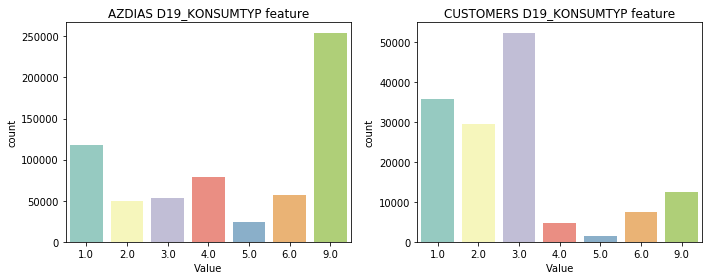

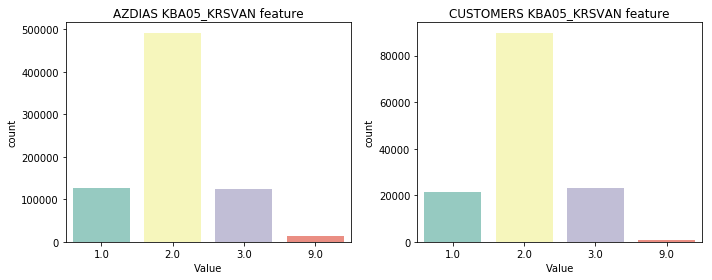

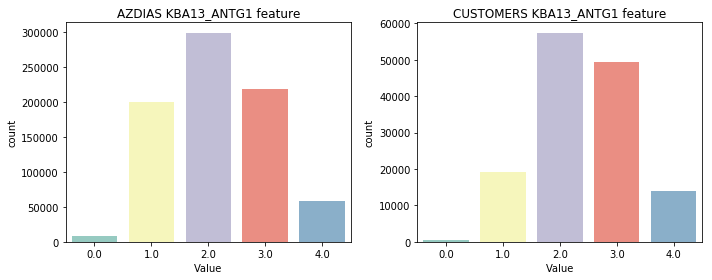

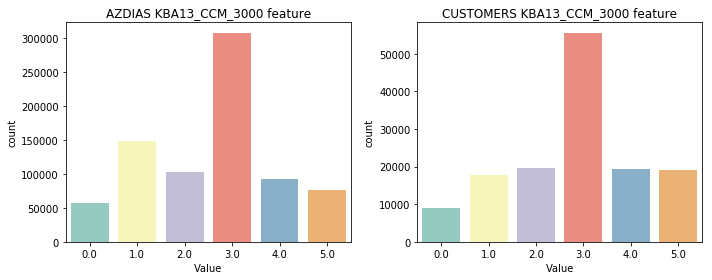

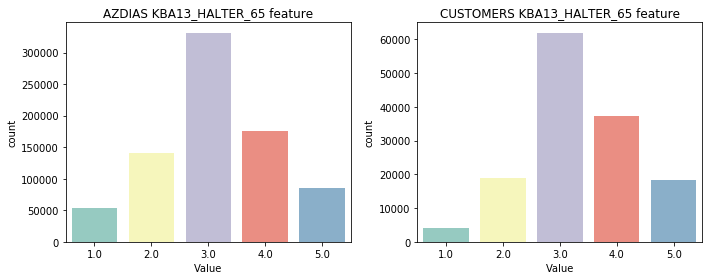

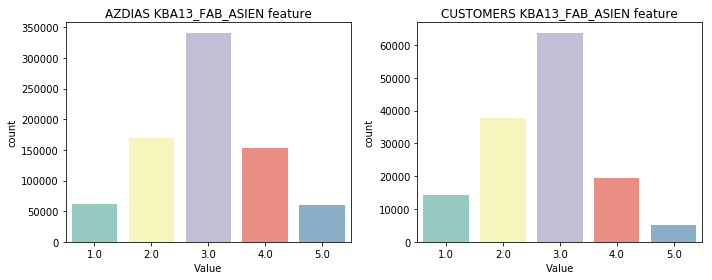

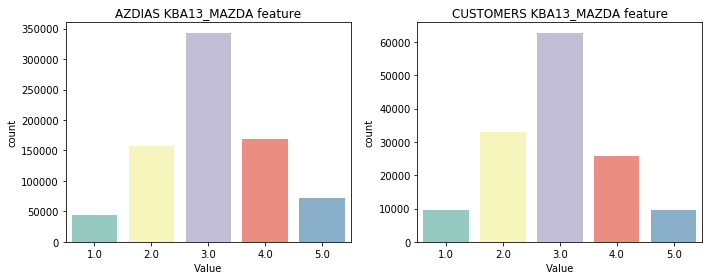

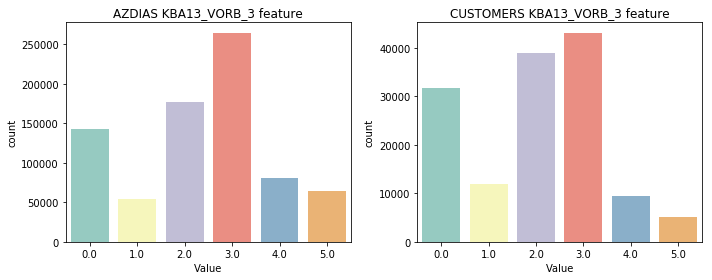

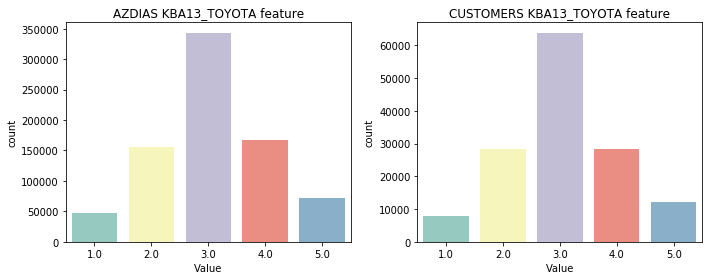

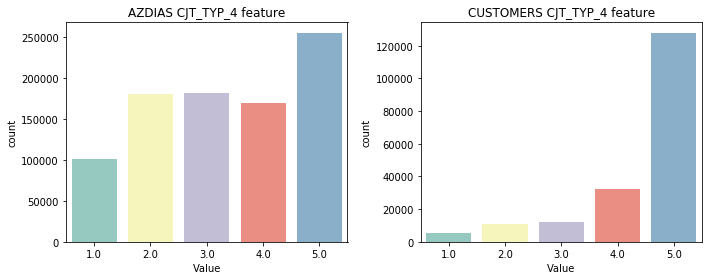

In [148]:
for i in random.sample(range(0,len(azdias.columns)-1),10):
    azdias_customers_plot(azdias.columns[i])

- From the random distribution map, the two data sets are distributed and similar

### 1.Deal with the numerical features

In [149]:
# define a drop features list
drop_features=set()

In [150]:
# in numerical_attribute: 
# {'MIN_GEBAEUDEJAHR', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_TITEL', 'ANZ_PERSONEN', 'GEBURTSJAHR', 'ANZ_HH_TITEL', 'KBA13_ANZAHL_PKW'}
my_azdias[list(numerical_attribute)].head()

,GEBURTSJAHR,ANZ_HH_TITEL,MIN_GEBAEUDEJAHR,ANZ_HAUSHALTE_AKTIV,ANZ_PERSONEN,KBA13_ANZAHL_PKW,ANZ_TITEL
0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,1996,0.0,1992.0,11.0,2.0,963.0,0.0
2,1979,0.0,1992.0,10.0,1.0,712.0,0.0
3,1957,0.0,1997.0,1.0,0.0,596.0,0.0
4,1963,0.0,1992.0,3.0,4.0,435.0,0.0


- 'MIN_GEBAEUDEJAHR' will be replaced by age.
- 'GEBURTSJAHR' will be replaced by age.

In [151]:
numerical_attribute

{'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'GEBURTSJAHR',
 'KBA13_ANZAHL_PKW',
 'MIN_GEBAEUDEJAHR'}

In [152]:
DIAS_attributes['Attribute'].value_counts()

CAMEO_DEU_2015                 44
LP_LEBENSPHASE_FEIN            40
CAMEO_DEUINTL_2015             26
ALTER_HH                       22
PRAEGENDE_JUGENDJAHRE          16
LP_LEBENSPHASE_GROB            12
GFK_URLAUBERTYP                12
D19_GESAMT_ONLINE_QUOTE_12     11
LP_FAMILIE_FEIN                11
D19_VERSAND_ONLINE_QUOTE_12    11
LP_FAMILIE_GROB                11
D19_BANKEN_ONLINE_QUOTE_12     11
D19_GESAMT_DATUM               10
LP_STATUS_FEIN                 10
WOHNDAUER_2008                 10
D19_BANKEN_OFFLINE_DATUM       10
D19_TELKO_ONLINE_DATUM         10
D19_VERSAND_OFFLINE_DATUM      10
D19_GESAMT_ONLINE_DATUM        10
ORTSGR_KLS9                    10
D19_BANKEN_ONLINE_DATUM        10
D19_TELKO_DATUM                10
D19_BANKEN_DATUM               10
D19_VERSAND_ONLINE_DATUM       10
CAMEO_DEUG_2015                10
D19_VERSAND_DATUM              10
HAUSHALTSSTRUKTUR              10
D19_TELKO_OFFLINE_DATUM        10
LP_STATUS_GROB                 10
D19_GESAMT_OFF

- I think the numeric features have only 1 values meaning.

In [153]:
attribute_value_number=[]
for i in my_azdias.columns:
    attribute_value_number.append((len(my_azdias[i].value_counts()),i))

In [154]:
print(sorted(attribute_value_number))

[(2, 'ANREDE_KZ'), (2, 'DSL_FLAG'), (2, 'GREEN_AVANTGARDE'), (2, 'HH_DELTA_FLAG'), (2, 'KBA05_SEG6'), (2, 'KONSUMZELLE'), (2, 'OST_WEST_KZ'), (2, 'SOHO_KZ'), (2, 'UNGLEICHENN_FLAG'), (2, 'VERS_TYP'), (3, 'HEALTH_TYP'), (3, 'KBA05_ANTG4'), (3, 'KBA05_KRSKLEIN'), (3, 'KBA05_KRSOBER'), (3, 'KBA05_KRSVAN'), (3, 'KBA05_KRSZUL'), (3, 'KBA05_MAXVORB'), (3, 'KBA13_ANTG4'), (3, 'KBA13_KMH_110'), (3, 'KBA13_KMH_251'), (3, 'KBA13_KW_30'), (3, 'NATIONALITAET_KZ'), (3, 'PLZ8_ANTG4'), (3, 'STRUKTURTYP'), (4, 'AGER_TYP'), (4, 'KBA05_ANHANG'), (4, 'KBA05_ANTG3'), (4, 'KBA05_MAXBJ'), (4, 'KBA05_MAXSEG'), (4, 'KBA05_MOD8'), (4, 'KBA05_MOTOR'), (4, 'KBA05_MOTRAD'), (4, 'KBA05_SEG1'), (4, 'KBA05_SEG7'), (4, 'KBA05_SEG8'), (4, 'KBA05_SEG9'), (4, 'KBA13_ANTG3'), (4, 'KBA13_KRSSEG_KLEIN'), (4, 'KBA13_KRSSEG_OBER'), (4, 'KBA13_KRSSEG_VAN'), (4, 'KBA13_KRSZUL_NEU'), (4, 'KBA13_MOTOR'), (4, 'KKK'), (4, 'PLZ8_ANTG3'), (4, 'SHOPPER_TYP'), (5, 'ALTERSKATEGORIE_GROB'), (5, 'CJT_KATALOGNUTZER'), (5, 'CJT_TYP_1'), (5

- numerical feature might have more value,so I will check the value count bigger than 30

In [155]:
# find out the value count bigger than 30
[x for x in attribute_value_number if x[0]>30]

[(891221, 'LNR'),
 (292, 'ANZ_HAUSHALTE_AKTIV'),
 (268, 'ANZ_STATISTISCHE_HAUSHALTE'),
 (45, 'CAMEO_DEU_2015'),
 (43, 'CAMEO_INTL_2015'),
 (35, 'D19_LETZTER_KAUF_BRANCHE'),
 (5162, 'EINGEFUEGT_AM'),
 (37, 'EINGEZOGENAM_HH_JAHR'),
 (56, 'EXTSEL992'),
 (117, 'GEBURTSJAHR'),
 (1261, 'KBA13_ANZAHL_PKW'),
 (41, 'LP_LEBENSPHASE_FEIN'),
 (32, 'MIN_GEBAEUDEJAHR'),
 (46, 'VERDICHTUNGSRAUM')]

In [156]:
# find more numberical attribute 
set([x[1] for x in attribute_value_number if x[0]>30])-numerical_attribute-drop_features-set(['LNR'])

{'ANZ_STATISTISCHE_HAUSHALTE',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'LP_LEBENSPHASE_FEIN',
 'VERDICHTUNGSRAUM'}

- LNR will be the index,
- EINGEFUEGT_AM,D19_LETZTER_KAUF_BRANCHE,EINGEZOGENAM_HH_JAHR I don't know what is it.

In [157]:
drop_features=drop_features|set(['EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE','EINGEZOGENAM_HH_JAHR'])

In [158]:
drop_features

{'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'EINGEZOGENAM_HH_JAHR'}

In [159]:
my_azdias['ANZ_STATISTISCHE_HAUSHALTE'].value_counts()

1.0      219119
2.0      121485
3.0       61478
4.0       44864
5.0       40133
6.0       38466
7.0       36589
8.0       32816
9.0       28500
10.0      24100
11.0      19461
12.0      16296
13.0      13040
14.0      10616
15.0       8939
16.0       7314
17.0       6136
18.0       5220
19.0       4465
20.0       3840
21.0       3433
22.0       3221
23.0       2633
24.0       2485
25.0       2384
26.0       2042
27.0       1995
28.0       1930
29.0       1712
30.0       1661
          ...  
258.0         5
228.0         5
177.0         5
242.0         5
218.0         4
216.0         4
239.0         4
203.0         4
241.0         4
209.0         4
262.0         4
198.0         4
284.0         4
309.0         4
245.0         3
182.0         3
248.0         3
229.0         3
371.0         3
289.0         3
449.0         3
175.0         2
165.0         2
227.0         2
189.0         2
190.0         2
336.0         2
197.0         2
133.0         1
314.0         1
Name: ANZ_STATISTISCHE_H

- It has many values so I think it's a numerical feature. 

In [160]:
numerical_attribute.add('ANZ_STATISTISCHE_HAUSHALTE')

In [161]:
my_azdias['EXTSEL992'].value_counts()

56.0    19722
31.0    14987
27.0    13269
38.0    12856
23.0    12742
36.0    12059
35.0    11308
55.0     9812
34.0     8583
50.0     6435
53.0     5686
37.0     5211
21.0     5114
54.0     4857
6.0      4815
41.0     4517
19.0     4445
29.0     4332
18.0     4315
39.0     4253
33.0     4199
25.0     4095
20.0     4069
26.0     3087
32.0     3041
15.0     2917
48.0     2916
17.0     2868
14.0     2832
40.0     2787
3.0      2783
2.0      2701
43.0     2602
46.0     2550
22.0     2244
24.0     2238
47.0     1659
1.0      1526
4.0      1468
13.0     1458
30.0     1457
5.0      1437
52.0     1415
16.0     1147
45.0     1087
12.0     1027
9.0       983
42.0      912
10.0      866
11.0      709
51.0      674
8.0       642
7.0       546
44.0      447
49.0      251
28.0      110
Name: EXTSEL992, dtype: int64

- It has many values so I think it's a numerical feature. 

In [162]:
numerical_attribute.add('EXTSEL992')

In [163]:
my_azdias['VERDICHTUNGSRAUM'].value_counts()

0.0     368782
1.0     111235
2.0      47613
3.0      29827
4.0      26996
5.0      24019
6.0      21882
7.0      13238
8.0      11864
10.0     11034
9.0       9425
13.0      8707
11.0      8226
14.0      8180
12.0      8046
15.0      6942
16.0      6435
17.0      5502
18.0      5061
20.0      3538
22.0      3492
21.0      3364
19.0      3300
23.0      3239
24.0      2980
25.0      2887
30.0      2648
27.0      2622
26.0      2569
29.0      2552
28.0      2454
32.0      2390
31.0      2313
33.0      2240
34.0      2054
36.0      1959
35.0      1769
39.0      1660
38.0      1622
44.0      1435
40.0      1359
37.0      1348
41.0      1329
42.0      1324
43.0      1321
45.0      1165
Name: VERDICHTUNGSRAUM, dtype: int64

- It has many values so I think it's a numerical feature. 

In [164]:
numerical_attribute.add('VERDICHTUNGSRAUM')

In [165]:
# find out the features that have more than 30 values
set([x[1] for x in attribute_value_number if x[0]>30])-numerical_attribute-drop_features-set(['LNR'])

{'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN'}

In [166]:
print(my_azdias['CAMEO_DEU_2015'].value_counts(),my_azdias['CAMEO_INTL_2015'].value_counts(),my_azdias['LP_LEBENSPHASE_FEIN'].value_counts())

6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: CAMEO_DEU_2015, dtype: int64 51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43.0    23942
25      22837
54.0    19184
22      19173
25.0    16791
23      15653
13      15272
45      15206
22.0    13982
55      13842
52      11836
23.0    11097
13.0    11064
31      11041
45.0    10926
34      10737
55.0    10113
15       9832
52.0     8706
44       8543
31.0 

- It has many values so I think it's a numerical feature. 

In [167]:
numerical_attribute.add('LP_LEBENSPHASE_FEIN')

In [168]:
print(numerical_attribute)

{'GEBURTSJAHR', 'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_HH_TITEL', 'LP_LEBENSPHASE_FEIN', 'MIN_GEBAEUDEJAHR', 'ANZ_HAUSHALTE_AKTIV', 'VERDICHTUNGSRAUM', 'ANZ_PERSONEN', 'KBA13_ANZAHL_PKW', 'EXTSEL992', 'ANZ_TITEL'}


- That's all,I accept the result of numerical features.

### 2.Deal with the categories features

In [169]:
# find out the categories features
categories_attribute=set(my_azdias.columns)-numerical_attribute-drop_features-set(['LNR'])
my_azdias_categories=my_azdias[list(categories_attribute)]

In [170]:
# See which data types are in the category properties
my_azdias_categories.columns.to_series().groupby(my_azdias_categories.dtypes).groups

{dtype('int64'): Index(['D19_BANKEN_REST', 'D19_RATGEBER', 'SEMIO_KULT', 'D19_HAUS_DEKO',
        'SEMIO_TRADV', 'SEMIO_KRIT', 'D19_BEKLEIDUNG_REST', 'D19_TELKO_DATUM',
        'D19_TELKO_REST', 'D19_VERSI_ANZ_12', 'D19_VERSAND_OFFLINE_DATUM',
        'D19_GESAMT_OFFLINE_DATUM', 'D19_VERSI_ANZ_24', 'D19_DIGIT_SERV',
        'FINANZ_UNAUFFAELLIGER', 'D19_BANKEN_GROSS', 'D19_GARTEN', 'KOMBIALTER',
        'D19_KINDERARTIKEL', 'D19_VOLLSORTIMENT', 'FINANZ_VORSORGER',
        'SEMIO_LUST', 'SEMIO_SOZ', 'D19_BANKEN_ANZ_12', 'D19_VERSAND_ANZ_24',
        'D19_VERSICHERUNGEN', 'D19_KOSMETIK', 'SEMIO_FAM', 'SEMIO_DOM',
        'D19_FREIZEIT', 'D19_VERSAND_REST', 'SEMIO_PFLICHT', 'D19_LEBENSMITTEL',
        'D19_NAHRUNGSERGAENZUNG', 'ANREDE_KZ', 'D19_VERSAND_DATUM',
        'SEMIO_VERT', 'ALTERSKATEGORIE_GROB', 'D19_BANKEN_OFFLINE_DATUM',
        'SEMIO_ERL', 'D19_REISEN', 'D19_GESAMT_ONLINE_DATUM',
        'D19_VERSI_ONLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_BILDUNG',
        'D19_TECHNI

In [171]:
# focus the object data type features ['CAMEO_DEUG_2015', 'OST_WEST_KZ', 'CAMEO_INTL_2015', 'CAMEO_DEU_2015']
# first CAMEO_DEUG_2015,CAMEO_INTL_2015,CAMEO_DEU_2015
CAMEO_list=[]
for l in azdias.columns.tolist():
    if 'CAMEO' in l:
        CAMEO_list.append(l)
print(CAMEO_list)

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015']


In [172]:
my_azdias_categories[CAMEO_list].head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015
0,NaN,NaN,NaN
1,8A,8,51
2,4C,4,24
3,2A,2,12
4,6B,6,43


In [173]:
print(my_azdias_categories['CAMEO_DEUG_2015'].value_counts())
print(my_azdias_categories['CAMEO_DEU_2015'].value_counts())
print(my_azdias_categories['CAMEO_INTL_2015'].value_counts())

8      78023
9      62578
6      61253
4      60185
8.0    56418
3      50360
2      48276
9.0    45599
7      45021
6.0    44621
4.0    43727
3.0    36419
2.0    34955
7.0    32912
5      32292
5.0    23018
1      20997
1.0    15215
X        373
Name: CAMEO_DEUG_2015, dtype: int64
6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
XX      373
Name: CAMEO_DEU_2015, dtype: int64
51      77576
51.0    56118
41      53459
24      52882
41.0    38877
24.0    38276
14      36524
43      32730
14.0    26360
54      26207
43

In [174]:
my_azdias_categories['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)
my_azdias_categories['CAMEO_INTL_2015'].replace('XX',np.nan,inplace=True)
my_azdias_categories['CAMEO_DEUG_2015']=my_azdias_categories['CAMEO_DEUG_2015'].astype('float')
my_azdias_categories['CAMEO_INTL_2015']=my_azdias_categories['CAMEO_INTL_2015'].astype('float')

c:\program files\python3\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
c:\program files\python3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\program files\python3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

In [175]:
my_azdias_categories[['CAMEO_DEUG_2015','CAMEO_INTL_2015']].corr()

,CAMEO_DEUG_2015,CAMEO_INTL_2015
CAMEO_DEUG_2015,1.000000,0.955588
CAMEO_INTL_2015,0.955588,1.000000


- according the attribute description 'CAMEO_DEU_2015' 'CAMEO_INTL_2015' include more detail than CAMEO_DEUG_2015.The correlation between  'CAMEO_DEUG_2015'and 'CAMEO_INTL_2015' is high.

In [176]:
# I will drop CAMEO_DEU_2015 and CAMEO_INTL_2015 
drop_features.add('CAMEO_DEU_2015')
drop_features.add('CAMEO_INTL_2015')

In [177]:
print(drop_features)

{'EINGEFUEGT_AM', 'CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEZOGENAM_HH_JAHR'}


In [178]:
# I will check the value count is 2 as binary_attribute
binary_attribute=set([x[1] for x in attribute_value_number if x[0]==2])

In [179]:
print(binary_attribute)

{'DSL_FLAG', 'SOHO_KZ', 'UNGLEICHENN_FLAG', 'KBA05_SEG6', 'OST_WEST_KZ', 'HH_DELTA_FLAG', 'VERS_TYP', 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'KONSUMZELLE'}


In [180]:
multiple_categories_attribute=set(my_azdias.columns)-numerical_attribute-drop_features-set(['LNR'])-binary_attribute

In [181]:
print(multiple_categories_attribute)

{'D19_BANKEN_REST', 'D19_RATGEBER', 'PLZ8_ANTG3', 'SEMIO_KULT', 'D19_HAUS_DEKO', 'KBA13_KW_110', 'KBA13_CCM_2000', 'SEMIO_TRADV', 'CJT_TYP_1', 'SEMIO_KRIT', 'D19_SOZIALES', 'D19_BEKLEIDUNG_REST', 'W_KEIT_KIND_HH', 'ONLINE_AFFINITAET', 'KBA13_KMH_250', 'KBA05_HERST5', 'KBA05_KRSKLEIN', 'KBA13_FAB_ASIEN', 'KBA05_VORB2', 'D19_TELKO_DATUM', 'KBA13_KW_50', 'KBA13_KW_0_60', 'KBA13_CCM_1800', 'KBA13_KMH_110', 'KBA13_KW_80', 'KBA13_BJ_2008', 'KKK', 'KBA13_NISSAN', 'D19_TELKO_REST', 'KBA05_ANTG3', 'LP_LEBENSPHASE_GROB', 'D19_VERSI_ANZ_12', 'D19_VERSAND_OFFLINE_DATUM', 'KBA05_MOD8', 'KBA13_SEG_MINIWAGEN', 'KBA13_KW_30', 'KBA13_SEG_KOMPAKTKLASSE', 'KBA05_GBZ', 'KBA13_CCM_1401_2500', 'ALTER_KIND2', 'KBA13_KRSSEG_OBER', 'RT_KEIN_ANREIZ', 'D19_GESAMT_OFFLINE_DATUM', 'KBA13_HHZ', 'KBA13_HERST_ASIEN', 'BALLRAUM', 'KBA13_HALTER_30', 'KBA05_SEG5', 'KBA05_AUTOQUOT', 'KBA13_HALTER_65', 'KBA13_CCM_1400', 'CJT_TYP_4', 'KBA13_VORB_1_2', 'ALTER_KIND4', 'D19_VERSI_ANZ_24', 'D19_DIGIT_SERV', 'KBA13_HERST_BMW_BE

In [182]:
my_azdias_categories_corr = my_azdias_categories[list(multiple_categories_attribute)].corr()

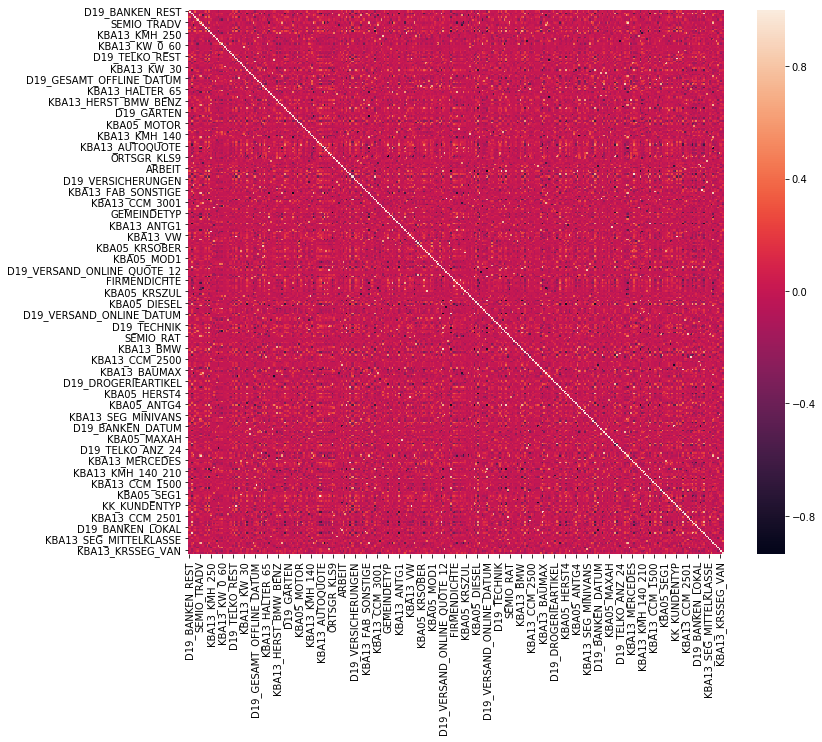

In [183]:
plt.figure(figsize=(12,10))
sns.heatmap(my_azdias_categories_corr)  
plt.show()

In [184]:
my_azdias_categories_corr_=my_azdias_categories_corr.replace(1,0)

In [185]:
# find out relevance features greater than 90%
categories_corr_list=[]
for i, row in my_azdias_categories_corr_.iterrows():
    corr_index=row[row.values>0.90].index
    if len(corr_index) !=0:
        corr_list=set(corr_index.tolist())
        corr_list.add(i)
        categories_corr_list.append(corr_list)

c:\program files\python3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


In [186]:
categories_corr_list

[{'KBA13_ANTG3', 'PLZ8_ANTG3'},
 {'KBA13_KMH_211', 'KBA13_KMH_250'},
 {'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB'},
 {'KBA13_HHZ', 'PLZ8_HHZ'},
 {'KBA13_GBZ', 'PLZ8_GBZ'},
 {'D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24'},
 {'LP_STATUS_FEIN', 'LP_STATUS_GROB'},
 {'KBA13_ANTG1', 'PLZ8_ANTG1'},
 {'KBA13_KMH_211', 'KBA13_KMH_250'},
 {'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB'},
 {'D19_GESAMT_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12'},
 {'D19_GESAMT_ONLINE_DATUM', 'D19_VERSAND_DATUM', 'D19_VERSAND_ONLINE_DATUM'},
 {'D19_GESAMT_ONLINE_DATUM', 'D19_VERSAND_DATUM', 'D19_VERSAND_ONLINE_DATUM'},
 {'D19_GESAMT_ONLINE_DATUM', 'D19_VERSAND_DATUM', 'D19_VERSAND_ONLINE_DATUM'},
 {'D19_GESAMT_ANZ_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24'},
 {'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_12'},
 {'D19_GESAMT_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12'},
 {'KBA13_ALTERHALTER_61', 'KBA13_HALTER_66'},
 {'KBA13_BAUMAX', 'PLZ8_B

In [187]:
# remove duplicate
categories_corr_list_ = []
for i in categories_corr_list:
    if len(categories_corr_list_)>0:
        add_flag=1
        for j in categories_corr_list_:
            if len(i-j)==0:
                add_flag=0
        if add_flag==1:
            categories_corr_list_.append(i)
    else:
        categories_corr_list_.append(i)
print(categories_corr_list_) 

[{'KBA13_ANTG3', 'PLZ8_ANTG3'}, {'KBA13_KMH_211', 'KBA13_KMH_250'}, {'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_GROB', 'LP_FAMILIE_FEIN'}, {'KBA13_HHZ', 'PLZ8_HHZ'}, {'KBA13_GBZ', 'PLZ8_GBZ'}, {'D19_GESAMT_ANZ_24', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_ANZ_12'}, {'LP_STATUS_GROB', 'LP_STATUS_FEIN'}, {'KBA13_ANTG1', 'PLZ8_ANTG1'}, {'D19_VERSAND_ONLINE_QUOTE_12', 'D19_GESAMT_ONLINE_QUOTE_12'}, {'D19_VERSAND_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM'}, {'D19_GESAMT_ANZ_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24'}, {'D19_GESAMT_ANZ_24', 'D19_GESAMT_ANZ_12', 'D19_VERSAND_ANZ_12'}, {'KBA13_ALTERHALTER_61', 'KBA13_HALTER_66'}, {'PLZ8_BAUMAX', 'KBA13_BAUMAX'}, {'D19_GESAMT_ANZ_24', 'D19_GESAMT_ANZ_12', 'D19_VERSAND_ANZ_24'}]


In [188]:
# drop some featrues according the categories_corr_list_ and DIAS Attributes - Values 2017.xlsx 
drop_features.add('KBA13_ANTG1')
drop_features.add('LP_FAMILIE_GROB')
drop_features.add('LP_FAMILIE_FEIN')
drop_features.add('KBA13_KMH_250')
drop_features.add('KBA13_HHZ')
drop_features.add('D19_GESAMT_ONLINE_QUOTE_12')
drop_features.add('KBA13_HALTER_66')
drop_features.add('LP_STATUS_GROB')
drop_features.add('D19_GESAMT_ANZ_24')
drop_features.add('D19_VERSAND_ANZ_24')
drop_features.add('D19_VERSAND_ANZ_12')
drop_features.add('KBA13_GBZ')
drop_features.add('KBA13_BAUMAX')
drop_features.add('KBA13_ANTG3')
drop_features.add('D19_GESAMT_ONLINE_DATUM')
drop_features.add('D19_VERSAND_ONLINE_DATUM')

- My standard is to exclude the absence of attribute descriptions, and then choose more and more value types.

In [189]:
multiple_categories_attribute=multiple_categories_attribute-drop_features

In [190]:
print(binary_attribute)

{'DSL_FLAG', 'SOHO_KZ', 'UNGLEICHENN_FLAG', 'KBA05_SEG6', 'OST_WEST_KZ', 'HH_DELTA_FLAG', 'VERS_TYP', 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'KONSUMZELLE'}


In [191]:
print(multiple_categories_attribute)

{'D19_BANKEN_REST', 'D19_RATGEBER', 'PLZ8_ANTG3', 'SEMIO_KULT', 'D19_HAUS_DEKO', 'KBA13_KW_110', 'KBA13_CCM_2000', 'SEMIO_TRADV', 'CJT_TYP_1', 'SEMIO_KRIT', 'D19_SOZIALES', 'D19_BEKLEIDUNG_REST', 'W_KEIT_KIND_HH', 'ONLINE_AFFINITAET', 'KBA05_HERST5', 'KBA05_KRSKLEIN', 'KBA13_FAB_ASIEN', 'KBA05_VORB2', 'D19_TELKO_DATUM', 'KBA13_KW_50', 'KBA13_KW_0_60', 'KBA13_CCM_1800', 'KBA13_KMH_110', 'KBA13_KW_80', 'KBA13_BJ_2008', 'KKK', 'KBA13_NISSAN', 'D19_TELKO_REST', 'KBA05_ANTG3', 'LP_LEBENSPHASE_GROB', 'D19_VERSI_ANZ_12', 'D19_VERSAND_OFFLINE_DATUM', 'KBA05_MOD8', 'KBA13_SEG_MINIWAGEN', 'KBA13_KW_30', 'KBA13_SEG_KOMPAKTKLASSE', 'KBA05_GBZ', 'KBA13_CCM_1401_2500', 'ALTER_KIND2', 'RT_KEIN_ANREIZ', 'D19_GESAMT_OFFLINE_DATUM', 'KBA13_HERST_ASIEN', 'BALLRAUM', 'KBA13_HALTER_30', 'KBA05_SEG5', 'KBA05_AUTOQUOT', 'KBA13_HALTER_65', 'KBA13_CCM_1400', 'CJT_TYP_4', 'KBA13_VORB_1_2', 'ALTER_KIND4', 'D19_VERSI_ANZ_24', 'D19_DIGIT_SERV', 'KBA13_HERST_BMW_BENZ', 'GFK_URLAUBERTYP', 'KBA13_KW_121', 'FINANZ_UNA

### 3.process the missing values and deal with some features

In [192]:
# deal with columns
azdias_col_null=(my_azdias.isnull().sum()/len(my_azdias)).sort_values(ascending=False)
customers_col_null=(my_customers.isnull().sum()/len(my_customers)).sort_values(ascending=False)

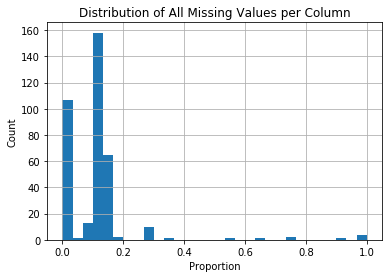

In [193]:
azdias_col_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Column');

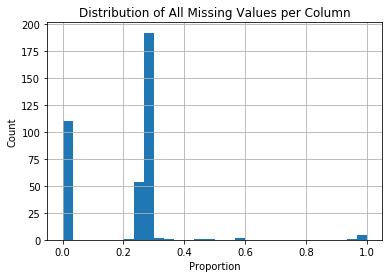

In [194]:
customers_col_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Column');

In [195]:
#remove the features that has over 30% missing rate
remove_features=set(azdias_col_null[azdias_col_null>0.3].index)|set(customers_col_null[customers_col_null>0.3].index)
print(remove_features)
# azdias.drop(labels=remove_features,axis=1,inplace=True)
# customers.drop(labels=remove_features,axis=1,inplace=True)
# print(azdias.shape,customers.shape)
drop_features=drop_features|remove_features
print(drop_features)

{'ALTER_KIND3', 'EXTSEL992', 'ALTER_KIND4', 'KKK', 'KK_KUNDENTYP', 'AGER_TYP', 'REGIOTYP', 'KBA05_BAUMAX', 'ALTER_HH', 'ALTER_KIND1', 'TITEL_KZ', 'ALTER_KIND2'}
{'LP_STATUS_GROB', 'EINGEFUEGT_AM', 'KBA13_HHZ', 'LP_FAMILIE_FEIN', 'KBA13_HALTER_66', 'CAMEO_DEU_2015', 'D19_VERSAND_ANZ_12', 'ALTER_KIND3', 'KBA13_BAUMAX', 'D19_GESAMT_ANZ_24', 'KBA13_GBZ', 'CAMEO_INTL_2015', 'EXTSEL992', 'KBA13_ANTG3', 'ALTER_KIND4', 'KKK', 'KK_KUNDENTYP', 'D19_GESAMT_ONLINE_DATUM', 'LP_FAMILIE_GROB', 'AGER_TYP', 'D19_GESAMT_ONLINE_QUOTE_12', 'KBA13_ANTG1', 'REGIOTYP', 'KBA13_KMH_250', 'KBA05_BAUMAX', 'ALTER_HH', 'ALTER_KIND1', 'D19_VERSAND_ONLINE_DATUM', 'TITEL_KZ', 'D19_LETZTER_KAUF_BRANCHE', 'ALTER_KIND2', 'D19_VERSAND_ANZ_24', 'EINGEZOGENAM_HH_JAHR'}


In [196]:
# redefine the categories_attribute and the numerical_attribute
numerical_attribute=numerical_attribute-drop_features
multiple_categories_attribute=multiple_categories_attribute-drop_features
binary_attribute=binary_attribute-drop_features

In [197]:
drop_features

{'AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_ONLINE_DATUM',
 'EINGEFUEGT_AM',
 'EINGEZOGENAM_HH_JAHR',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KBA13_ANTG1',
 'KBA13_ANTG3',
 'KBA13_BAUMAX',
 'KBA13_GBZ',
 'KBA13_HALTER_66',
 'KBA13_HHZ',
 'KBA13_KMH_250',
 'KKK',
 'KK_KUNDENTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_GROB',
 'REGIOTYP',
 'TITEL_KZ'}

In [198]:
my_azdias.drop(labels=drop_features,axis=1,inplace=True)
my_customers.drop(labels=drop_features,axis=1,inplace=True)

In [199]:
# deal with rows
azdias_row_null=(my_azdias.isnull().mean(axis=1)).sort_values(ascending=False)
customers_row_null=(my_customers.isnull().mean(axis=1)).sort_values(ascending=False)

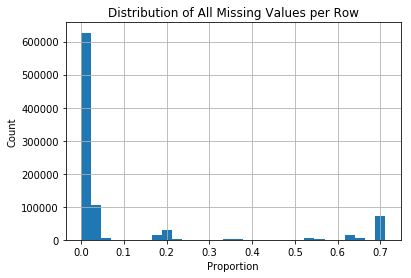

In [200]:
azdias_row_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Row');

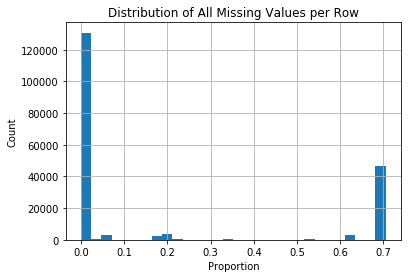

In [201]:
customers_row_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Row');

In [202]:
print(my_azdias.shape,my_customers.shape)

(891221, 333) (191652, 336)


In [203]:
#remove the row that has over 10% missing rate
azdias_remove_row=azdias_row_null[azdias_row_null>0.1].index
customers_remove_row=customers_row_null[customers_row_null>0.1].index

my_azdias.drop(index=azdias_remove_row,axis=0,inplace=True)
my_customers.drop(index=customers_remove_row,axis=0,inplace=True)

In [204]:
print(my_azdias.shape,my_customers.shape)

(737261, 333) (134245, 336)


In [205]:
print(my_azdias.isnull().mean().mean())
print(my_customers.isnull().mean().mean())

0.006961710435785424
0.0022087370461611588


In [206]:
# set index
my_azdias.set_index('LNR',inplace=True)
my_customers.set_index('LNR',inplace=True)

In [207]:
# dorp 3 attribute that only in my_customers dataset  
my_customers.drop(labels=['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'],axis=1,inplace=True)

### There are three types of data processing: numerical features, binary features and multiple categories features

In [209]:
# deal with the numerical features
# deal with the 'MIN_GEBAEUDEJAHR' , 'GEBURTSJAHR'
my_azdias['MIN_GEBAEUDEJAHR']=2017-my_azdias['MIN_GEBAEUDEJAHR']
my_azdias['GEBURTSJAHR']=2017-my_azdias['GEBURTSJAHR']

my_customers['MIN_GEBAEUDEJAHR']=2017-my_customers['MIN_GEBAEUDEJAHR']
my_customers['GEBURTSJAHR']=2017-my_customers['GEBURTSJAHR']

In [210]:
# fill the missing data in numerical_attribute
for l in numerical_attribute:
    my_azdias[l]=my_azdias[l].fillna(value=round(my_azdias[l].mean()))
    my_customers[l]=my_customers[l].fillna(value=round(my_customers[l].mean()))

In [211]:
len(my_azdias[list(numerical_attribute)].isnull().any()[my_azdias[list(numerical_attribute)].isnull().any()==True].index)

0

In [212]:
len(my_customers[list(numerical_attribute)].isnull().any()[my_customers[list(numerical_attribute)].isnull().any()==True].index)

0

- numerical features complete

In [213]:
# deal with the multiple_categories_attribute
my_azdias[list(multiple_categories_attribute)].columns.to_series(multiple_categories_attribute).groupby(my_azdias.dtypes).groups

{dtype('int64'): Index(['D19_BANKEN_REST', 'D19_RATGEBER', 'SEMIO_KULT', 'D19_HAUS_DEKO',
        'SEMIO_TRADV', 'SEMIO_KRIT', 'D19_BEKLEIDUNG_REST', 'D19_TELKO_DATUM',
        'D19_TELKO_REST', 'D19_VERSI_ANZ_12', 'D19_VERSAND_OFFLINE_DATUM',
        'D19_GESAMT_OFFLINE_DATUM', 'D19_VERSI_ANZ_24', 'D19_DIGIT_SERV',
        'FINANZ_UNAUFFAELLIGER', 'D19_BANKEN_GROSS', 'D19_GARTEN', 'KOMBIALTER',
        'D19_KINDERARTIKEL', 'D19_VOLLSORTIMENT', 'FINANZ_VORSORGER',
        'SEMIO_LUST', 'SEMIO_SOZ', 'D19_BANKEN_ANZ_12', 'D19_VERSICHERUNGEN',
        'D19_KOSMETIK', 'SEMIO_FAM', 'SEMIO_DOM', 'D19_FREIZEIT',
        'D19_VERSAND_REST', 'SEMIO_PFLICHT', 'D19_LEBENSMITTEL',
        'D19_NAHRUNGSERGAENZUNG', 'D19_VERSAND_DATUM', 'SEMIO_VERT',
        'ALTERSKATEGORIE_GROB', 'D19_BANKEN_OFFLINE_DATUM', 'SEMIO_ERL',
        'D19_REISEN', 'D19_VERSI_ONLINE_DATUM', 'D19_BILDUNG', 'D19_TECHNIK',
        'D19_GESAMT_ANZ_12', 'SEMIO_RAT', 'D19_BUCH_CD', 'D19_TELKO_ANZ_12',
        'D19_ENERGIE', 'D

In [214]:
# deal with object in the multiple_categories_attribute
my_azdias['CAMEO_DEUG_2015'].value_counts()

8      74751
6      58202
9      57473
4      55290
8.0    54102
2      44418
3      44189
6.0    42486
9.0    41978
7      41859
4.0    40292
2.0    32189
3.0    32128
7.0    30621
5      28976
5.0    20736
1      19837
1.0    14394
X        284
Name: CAMEO_DEUG_2015, dtype: int64

In [215]:
# deal with the 'CAMEO_DEUG_2015',replace the X value by np.nan
my_azdias['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)
my_customers['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)

In [216]:
my_azdias['CAMEO_DEUG_2015']=my_azdias['CAMEO_DEUG_2015'].astype('float')
my_customers['CAMEO_DEUG_2015']=my_customers['CAMEO_DEUG_2015'].astype('float')

In [217]:
# check the multiple_categories_attribute value
attribute_value_number=[]
for i in multiple_categories_attribute:
    attribute_value_number.append((len(my_azdias[i].value_counts()),i))
print(sorted(attribute_value_number))

[(3, 'HEALTH_TYP'), (3, 'KBA05_ANTG4'), (3, 'KBA05_KRSKLEIN'), (3, 'KBA05_KRSOBER'), (3, 'KBA05_KRSVAN'), (3, 'KBA05_KRSZUL'), (3, 'KBA05_MAXVORB'), (3, 'KBA13_ANTG4'), (3, 'KBA13_KMH_110'), (3, 'KBA13_KMH_251'), (3, 'KBA13_KW_30'), (3, 'NATIONALITAET_KZ'), (3, 'PLZ8_ANTG4'), (3, 'STRUKTURTYP'), (4, 'D19_TELKO_ONLINE_QUOTE_12'), (4, 'KBA05_ANHANG'), (4, 'KBA05_ANTG3'), (4, 'KBA05_MAXBJ'), (4, 'KBA05_MAXSEG'), (4, 'KBA05_MOD8'), (4, 'KBA05_MOTOR'), (4, 'KBA05_MOTRAD'), (4, 'KBA05_SEG1'), (4, 'KBA05_SEG7'), (4, 'KBA05_SEG8'), (4, 'KBA05_SEG9'), (4, 'KBA13_KRSSEG_KLEIN'), (4, 'KBA13_KRSSEG_OBER'), (4, 'KBA13_KRSSEG_VAN'), (4, 'KBA13_KRSZUL_NEU'), (4, 'KBA13_MOTOR'), (4, 'PLZ8_ANTG3'), (4, 'SHOPPER_TYP'), (5, 'ALTERSKATEGORIE_GROB'), (5, 'CJT_KATALOGNUTZER'), (5, 'CJT_TYP_1'), (5, 'CJT_TYP_2'), (5, 'CJT_TYP_3'), (5, 'CJT_TYP_4'), (5, 'CJT_TYP_5'), (5, 'CJT_TYP_6'), (5, 'FINANZ_ANLEGER'), (5, 'FINANZ_HAUSBAUER'), (5, 'FINANZ_MINIMALIST'), (5, 'FINANZ_SPARER'), (5, 'FINANZ_UNAUFFAELLIGER'), 

In [218]:
my_azdias.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EWDICHTE,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG2,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGEOT,KBA13_RENAULT,KBA13_SEG_GELAENDEWAGEN,KBA13_SEG_GROSSRAUMVANS,KBA13_SEG_KLEINST,KBA13_SEG_KLEINWAGEN,KBA13_SEG_KOMPAKTKLASSE,KBA13_SEG_MINIVANS,KBA13_SEG_MINIWAGEN,KBA13_SEG_MITTELKLASSE,KBA13_SEG_OBEREMITTELKLASSE,KBA13_SEG_OBERKLASSE,KBA13_SEG_SONSTIGE,KBA13_SEG_SPORTWAGEN,KBA13_SEG_UTILITIES,KBA13_SEG_VAN,KBA1

In [219]:
%%time
my_azdias[list(multiple_categories_attribute)]=my_azdias[list(multiple_categories_attribute)].astype('float')
my_customers[list(multiple_categories_attribute)]=my_customers[list(multiple_categories_attribute)].astype('float')

Wall time: 18.8 s


In [220]:
for l in multiple_categories_attribute:
    my_azdias[l].fillna(my_azdias[l].mode()[0], inplace=True)
    my_customers[l].fillna(my_customers[l].mode()[0], inplace=True)

In [221]:
%%time
my_azdias[list(multiple_categories_attribute)]=my_azdias[list(multiple_categories_attribute)].astype('int')
my_customers[list(multiple_categories_attribute)]=my_customers[list(multiple_categories_attribute)].astype('int')

Wall time: 2min 38s


- multiple_categories_attribute features complete

In [222]:
# deal with the binary_attribute
my_azdias[list(binary_attribute)].head()

,DSL_FLAG,SOHO_KZ,UNGLEICHENN_FLAG,KBA05_SEG6,OST_WEST_KZ,HH_DELTA_FLAG,VERS_TYP,ANREDE_KZ,GREEN_AVANTGARDE,KONSUMZELLE
LNR,,,,,,,,,,
910220,1.0,1.0,1.0,1.0,W,0.0,2.0,2,0,1.0
910225,1.0,0.0,0.0,0.0,W,0.0,1.0,2,1,0.0
910226,1.0,0.0,0.0,0.0,W,NaN,1.0,2,0,0.0
910241,1.0,0.0,0.0,0.0,W,0.0,2.0,1,0,0.0
910244,1.0,0.0,0.0,0.0,W,0.0,2.0,2,0,0.0


In [223]:
# Replace  the values of 'OST_WEST_KZ' 'VERS_TYP' 'ANREDE_KZ' with 1 and 0
# OST_WEST_KZ
my_azdias.loc[my_azdias['OST_WEST_KZ'] =='W','OST_WEST_KZ']=1
my_azdias.loc[my_azdias['OST_WEST_KZ'] =='O','OST_WEST_KZ']=0
# ANREDE_KZ
my_azdias['ANREDE_KZ']=my_azdias['ANREDE_KZ']-1
# VERS_TYP
my_azdias['VERS_TYP']=my_azdias['VERS_TYP']-1

# OST_WEST_KZ
my_customers.loc[my_customers['OST_WEST_KZ'] =='W','OST_WEST_KZ']=1
my_customers.loc[my_customers['OST_WEST_KZ'] =='O','OST_WEST_KZ']=0
# ANREDE_KZ
my_customers['ANREDE_KZ']=my_customers['ANREDE_KZ']-1
# VERS_TYP
my_customers['VERS_TYP']=my_customers['VERS_TYP']-1


In [224]:
my_azdias[list(binary_attribute)].head()

,DSL_FLAG,SOHO_KZ,UNGLEICHENN_FLAG,KBA05_SEG6,OST_WEST_KZ,HH_DELTA_FLAG,VERS_TYP,ANREDE_KZ,GREEN_AVANTGARDE,KONSUMZELLE
LNR,,,,,,,,,,
910220,1.0,1.0,1.0,1.0,1,0.0,1.0,1,0,1.0
910225,1.0,0.0,0.0,0.0,1,0.0,0.0,1,1,0.0
910226,1.0,0.0,0.0,0.0,1,NaN,0.0,1,0,0.0
910241,1.0,0.0,0.0,0.0,1,0.0,1.0,0,0,0.0
910244,1.0,0.0,0.0,0.0,1,0.0,1.0,1,0,0.0


In [225]:
# fill the nan with the mode value
for l in binary_attribute:
    my_azdias[l].fillna(my_azdias[l].mode()[0], inplace=True)
    my_customers[l].fillna(my_customers[l].mode()[0], inplace=True)

In [226]:
%%time
my_azdias[list(binary_attribute)]=my_azdias[list(binary_attribute)].astype('int')
my_customers[list(binary_attribute)]=my_customers[list(binary_attribute)].astype('int')

Wall time: 412 ms


- binary_attribute features complete

In [227]:
# To reduce the memory use of PCA, I choose almost categories to ordinal with DIAS_Attributes

In [228]:
print(my_azdias.shape,my_customers.shape)

(737261, 332) (134245, 332)


In [229]:
%%time
my_azdias.to_pickle("my_azdias.pkl")
my_customers.to_pickle("my_customers.pkl")

Wall time: 4.17 s


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### metrics
Use the Silhoutte score to get best segmentation of customers

In [230]:
%%time
if  'my_azdias' in locals() and 'my_customers' in locals():
    pass
else:
    my_azdias=pd.read_pickle("my_azdias.pkl")
    my_customers_df=pd.read_pickle("my_customers.pkl")

Wall time: 0 ns


In [231]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

In [237]:
%%time
# scale the numerical attribute
scaler = preprocessing.StandardScaler()
scaled = scaler.fit_transform(my_azdias[list(numerical_attribute|multiple_categories_attribute)]) 
my_azdias_scaled_df=pd.DataFrame(scaled, columns=list(numerical_attribute|multiple_categories_attribute),index=my_azdias.index)

Wall time: 10.6 s


In [239]:
my_azdias_df=pd.concat([my_azdias_scaled_df, my_azdias[list(binary_attribute)]], axis=1)

In [240]:
my_azdias_df.isnull().sum().sum()

0

In [242]:
my_azdias_df.shape

(737261, 332)

In [252]:
%%time
kmeans_avg=[]
kmeans_res_li=[]

# Over a number of different cluster counts...
for ind in range(2,30):
    # run k-means clustering on the data and...
    print('For Cluster',ind,'Processing is going on')
    kmeans=KMeans(n_clusters=ind, random_state=0)
    res_kmeans=kmeans.fit_predict(my_azdias_df)
    kmeans_res_li.append(res_kmeans)
    # compute the average within-cluster distances. 
    kmeans_avg.append((kmeans.score(my_azdias_df)/len(my_azdias_df))*-1)

For Cluster 2 Processing is going on
For Cluster 3 Processing is going on
For Cluster 4 Processing is going on
For Cluster 5 Processing is going on
For Cluster 6 Processing is going on
For Cluster 7 Processing is going on
For Cluster 8 Processing is going on
For Cluster 9 Processing is going on
For Cluster 10 Processing is going on
For Cluster 11 Processing is going on
For Cluster 12 Processing is going on
For Cluster 13 Processing is going on
For Cluster 14 Processing is going on
For Cluster 15 Processing is going on
For Cluster 16 Processing is going on
For Cluster 17 Processing is going on
For Cluster 18 Processing is going on
For Cluster 19 Processing is going on
For Cluster 20 Processing is going on
For Cluster 21 Processing is going on
For Cluster 22 Processing is going on
For Cluster 23 Processing is going on
For Cluster 24 Processing is going on
For Cluster 25 Processing is going on
For Cluster 26 Processing is going on
For Cluster 27 Processing is going on
For Cluster 28 Proce

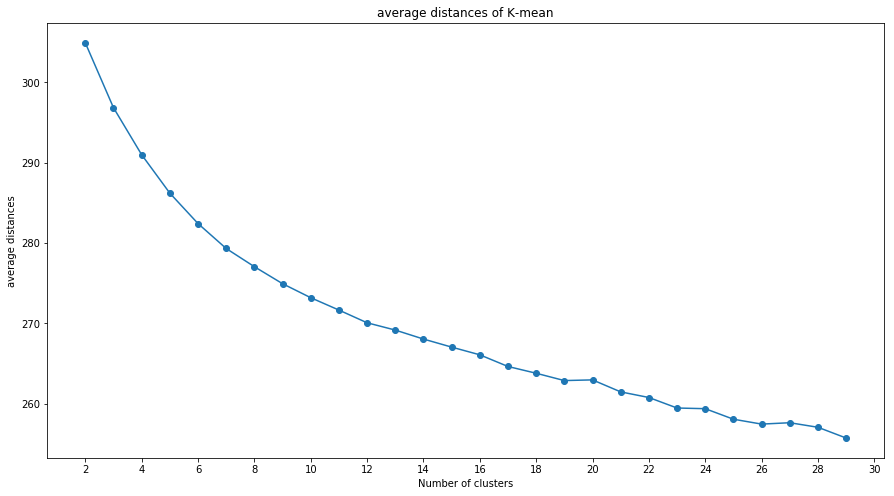

In [253]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(figsize=(15,8)) 
plt.title('average distances of K-mean')
plt.xlabel('Number of clusters')
plt.ylabel('average distances')
plt.xticks([0,2,4,6,8,10,12,14,16,18,20,22,24,26,28],[2,4,6,8,10,12,14,16,18,20,22,24,26,28,30])
plt.plot(kmeans_avg,marker='o')

In [251]:
def k_score(n,k,df):
    clusterer = KMeans(n_clusters=n,random_state=0).fit(df)
    s = df.sample(k)
    p = clusterer.predict(s)
    score = silhouette_score(s,p)
    return score

In [258]:
%%time

# find out the best number cluster 
k_list=[]
kmeans_score=[]
for i in range(15,20):
    print("for "+str(i)+" cluster")
    k_list.append(i)
    kmeans_score.append(k_score(i,10000,my_azdias_df))

for 15 cluster
for 16 cluster
for 17 cluster
for 18 cluster
for 19 cluster
Wall time: 3h 21min 45s


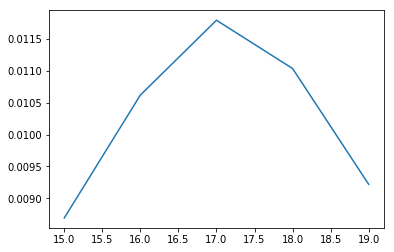

In [262]:
# find out the best number cluster 
plt.plot(k_list,kmeans_score)

- I think 17 is the best.

### Use my_azdias with PCA and Use the same parameter on my_customers

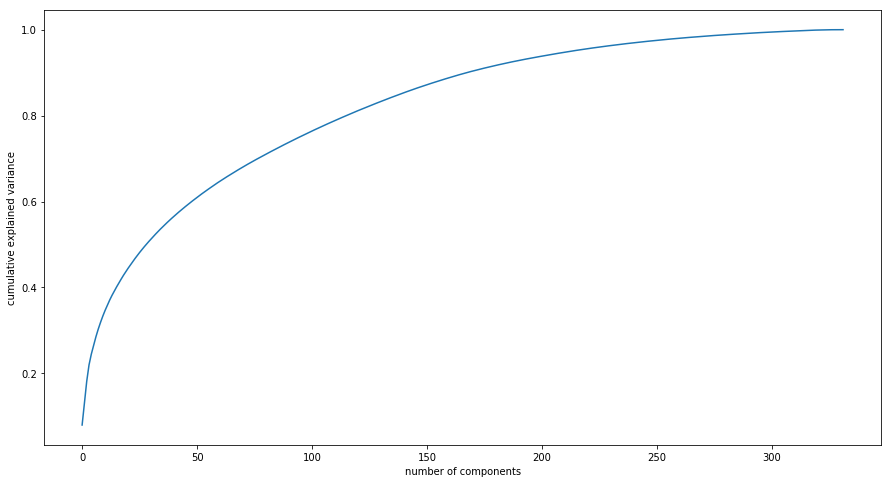

Wall time: 41.2 s


In [241]:
%%time
# Use the PCA to reduce the dimensions
plt.figure(figsize=(15,8)) 
pca = PCA().fit(my_azdias_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

Wall time: 555 ms


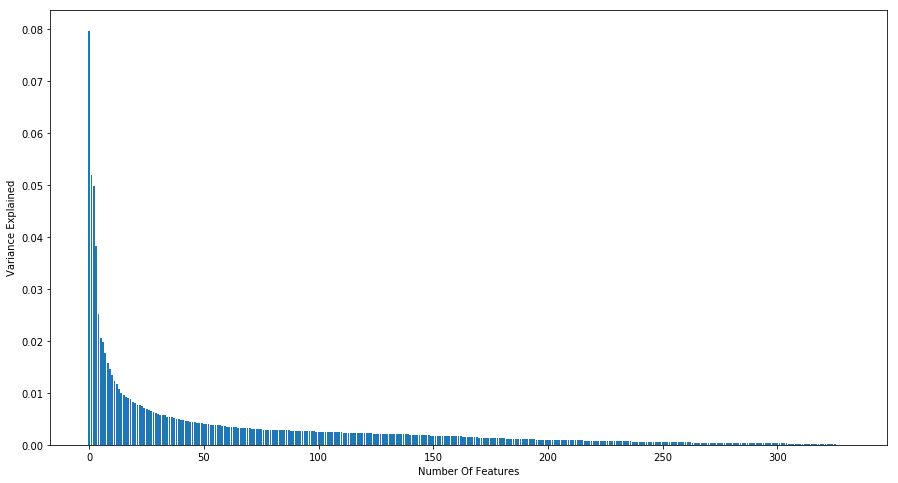

In [244]:
%%time
# Investigate the variance accounted for by each principal component.
plt.figure(figsize=(15,8)) 
explained_variance_ratio=[val for val in pca.explained_variance_ratio_]
cv=np.cumsum(np.round(explained_variance_ratio, decimals=3))
plt.ylabel('Variance Explained')
plt.xlabel('Number Of Features')
plt.bar(range(0,len(explained_variance_ratio)),explained_variance_ratio)

- I have done dimensionality reduction by getting explained ratio of principal components, As i observed 120 components/ eigen values were sufficient to explain more 80% variance in data so I opted that out. 

In [265]:
pca = PCA(n_components=120)
principalComponents_updated = pca.fit_transform(my_azdias_df)
first_comp=pca.components_[0]
first_comp_sorted=sorted(first_comp,reverse=True)
first_comp_index=sorted(range(len(first_comp)), key=lambda k: first_comp[k])

In [ ]:
%%time

# find out the best number cluster 
PCA_k_list=[]
PCA_kmeans_score=[]
for i in range(15,20):
    print("for "+str(i)+" cluster")
    PCA_k_list.append(i)
    PCA_kmeans_score.append(k_score(i,10000,principalComponents_updated))

for 15 cluster


In [ ]:
cols_sorted=my_azdias_df.columns[first_comp_index]
positive_index=first_comp_index[:10]
negative_index=first_comp_index[-10:]
positive_cols=cols_sorted[:10]
negative_cols=cols_sorted[-10:]
positive_weights=first_comp_sorted[:10]
negative_weights=first_comp_sorted[-10:]
for i in range(10):
    print('Positive: ',positive_index[i],positive_cols[i],positive_weights[i],' Negative: ',negative_index[i],negative_cols[i],negative_weights[i])

In [ ]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def weightsOfPca(componentIndex):
    components=pca.components_[componentIndex]
    componentspd=pd.DataFrame(components,columns=['weight'])
    componentspd['name']=list(my_azdias_df.columns)
    print(componentspd.sort_values(by='weight',ascending=False))

In [ ]:
# weightsOfPca(0)

In [ ]:
# weightsOfPca(1)

In [ ]:
def pca_analysis(ind):
    first_comp=pca.components_[ind]
    first_comp_sorted=sorted(first_comp,reverse=True)
    first_comp_index=sorted(range(len(first_comp)), key=lambda k: first_comp[k])
    cols_sorted=scaled_df.columns[first_comp_index]
    positive_index=first_comp_index[:10]
    negative_index=first_comp_index[-10:]
    positive_cols=cols_sorted[:10]
    negative_cols=cols_sorted[-10:]
    positive_weights=first_comp_sorted[:10]
    negative_weights=first_comp_sorted[-10:]
    for i in range(10):
        print('Positive: ',positive_index[i],positive_cols[i],positive_weights[i],' Negative: ',negative_index[i],negative_cols[i],negative_weights[i])

In [ ]:
# pca_analysis(1)

In [ ]:
# pca_analysis(2)

In [263]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans=KMeans(n_clusters=17, random_state=0)
AZDIAS_kmeans_17=kmeans.fit_predict(my_azdias_df)

In [264]:
print(AZDIAS_kmeans_17)

[14 14  4 ... 11  1 13]


In [300]:
# Do it for CUSTOMERS

scaled = scaler.fit_transform(my_azdias[list(numerical_attribute|multiple_categories_attribute)]) 
my_azdias_scaled_df=pd.DataFrame(scaled, columns=list(numerical_attribute|multiple_categories_attribute),index=my_azdias.index)

my_customers_df=pd.concat([my_azdias_scaled_df, my_azdias[list(binary_attribute)]], axis=1)

principalComponents_CUSTOMERS = pca.fit_transform(my_customers_df)
CUSTOMERS_kmeans_17=kmeans.predict(principalComponents_CUSTOMERS)

In [301]:
print(CUSTOMERS_kmeans_17)

[15  8  7 ...  6 12  9]


In [304]:
AZDIAS_list=np.bincount(AZDIAS_kmeans_17)
print(AZDIAS_list)
CUSTOMERS_list=np.bincount(CUSTOMERS_kmeans_17)
print(CUSTOMERS_list)

[49678 54012 65316 58419 42873 51516 37575 42731 56092 49233 34503 61199
   706  1498 60327 27824 43713]
[ 3641  6778  2758 12490  7728 10828 12086 12191 10902 10754  3175  8095
  7434  2650  4373 13967  4395]


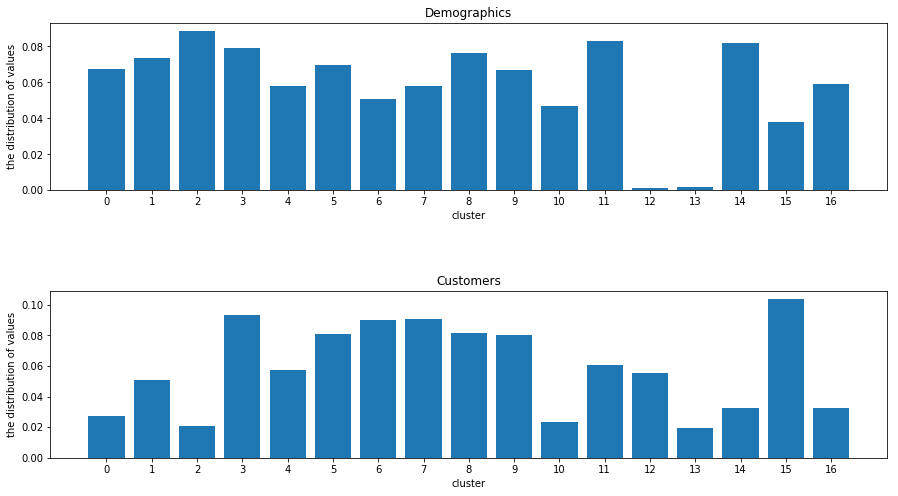

In [318]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.


percent_bin_list = list(map(lambda i: i/len(AZDIAS_kmeans_17), AZDIAS_list)) 
customers_percent_bin_list = list(map(lambda i: i/len(CUSTOMERS_kmeans_17), CUSTOMERS_list)) 
plt.figure(figsize=(15,8)) 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=None, hspace=0.6)

ax1=plt.subplot(211)
plt.bar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],percent_bin_list)
ax1.set_title('Demographics')
ax1.set_xlabel('cluster')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
ax1.set_ylabel('the distribution of values')

ax2=plt.subplot(212)
plt.bar([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],customers_percent_bin_list)
ax2.set_title('Customers')
ax2.set_xlabel('cluster')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
ax2.set_ylabel('the distribution of values')
plt.show()

In [319]:
overrepresented=kmeans.cluster_centers_[8]
print(overrepresented)

[ 6.42683308e+00 -3.30155582e+00 -1.43480498e+00  4.38156699e-02
  3.12733024e-01 -9.62049096e-01 -3.45042828e-01  9.25786503e-01
  8.79831966e-01 -1.77679668e-01 -6.55321648e-01  8.90431335e-02
 -2.95205592e-02  1.80692619e-01 -5.89831518e-01 -4.88899768e-01
  9.52345882e-02 -1.98003530e-01 -2.84024654e-01  6.87243412e-01
 -1.93351866e-01 -1.44223186e-01  1.61814572e-01 -2.55260701e-01
  5.36138405e-02  2.32687635e-01 -5.06165049e-01 -1.82305935e-01
 -2.08983984e-01  4.59989825e-01  1.10012147e-01 -1.46975833e-01
 -2.46193106e-02 -4.46759743e-03  1.10075857e-01  2.30286013e-02
  8.45047148e-03 -4.77593098e-03  1.08720205e-01 -9.31314486e-02
 -4.37189882e-02 -3.40007914e-02  1.38301980e-01  5.35878357e-02
 -5.46475936e-02 -1.38696029e-01 -6.16750181e-02 -1.55234515e-01
 -5.45501451e-02  1.65420975e-02 -6.85713038e-02  1.28893081e-02
 -3.41388923e-02  1.07927087e-02  8.87050016e-02 -7.44169016e-02
  1.27879865e-01 -5.60671024e-02  8.22962711e-02 -1.15181564e-01
  3.37259343e-02  5.07670

In [320]:
# check the details
overrepresentedpd=pd.DataFrame(overrepresented,columns=['weight'])
# overrepresentedpd['rank']=overrepresentedpd.index
print(overrepresentedpd.sort_values(by='weight',ascending=False))

       weight
0    6.426833
7    0.925787
8    0.879832
19   0.687243
29   0.459990
4    0.312733
25   0.232688
13   0.180693
22   0.161815
42   0.138302
56   0.127880
80   0.126809
112  0.119738
34   0.110076
30   0.110012
38   0.108720
118  0.107490
116  0.099716
16   0.095235
77   0.091809
11   0.089043
54   0.088705
82   0.088245
58   0.082296
70   0.080122
115  0.079190
65   0.074347
97   0.057206
24   0.053614
43   0.053588
..        ...
90  -0.066200
96  -0.067083
50  -0.068571
88  -0.068772
55  -0.074417
39  -0.093131
59  -0.115182
66  -0.128865
45  -0.138696
21  -0.144223
31  -0.146976
63  -0.152758
47  -0.155235
75  -0.156755
9   -0.177680
27  -0.182306
20  -0.193352
17  -0.198004
71  -0.205041
28  -0.208984
23  -0.255261
18  -0.284025
6   -0.345043
15  -0.488900
26  -0.506165
14  -0.589832
10  -0.655322
5   -0.962049
2   -1.434805
1   -3.301556

[120 rows x 1 columns]


In [322]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
underrepresented=kmeans.cluster_centers_[14]
print(underrepresented)

[ 7.96495733e+00 -3.48328732e+00  6.85052780e+00  2.87460166e+00
 -2.25139560e+00  9.45252779e-01  3.95171683e-01 -1.62835630e-01
 -2.97376325e-02 -4.85804683e-01  1.11461276e+00 -4.59866849e-02
  2.14482881e-01 -3.36351329e-01 -8.20699252e-02 -1.70286454e-01
  4.91119479e-02 -1.68278023e-01  1.81961100e-01 -1.02095241e-01
  8.49806368e-02  7.61043651e-02  1.92873613e-03  4.96248272e-01
  8.98007489e-02 -5.70641540e-01  4.04585382e-01 -6.63398066e-02
  1.93484996e-02 -2.08665360e-01  6.10234323e-02 -1.72777496e-02
 -3.34510255e-01  2.96791129e-01 -4.69982140e-02  9.87909672e-02
 -4.50765361e-02 -1.00238226e-01 -1.61958457e-01  9.87755205e-02
 -2.83740056e-02  6.45191710e-02  1.00055514e-01  4.19931734e-02
  8.76730466e-02 -2.77294515e-02 -4.31299577e-02 -5.94857478e-02
  6.20443859e-02 -3.45470092e-02 -8.52926436e-02 -2.15131951e-01
  4.08579591e-01  2.22428333e-01 -8.50844397e-02 -8.40531734e-02
  8.35059322e-02  8.32769871e-02 -2.03879364e-01  2.34395202e-02
 -2.81831632e-01 -1.93164

In [323]:
# check the details
underrepresentedpd=pd.DataFrame(underrepresented,columns=['weight'])
# overrepresentedpd['rank']=overrepresentedpd.index
print(underrepresentedpd.sort_values(by='weight',ascending=False))

       weight
0    7.964957
2    6.850528
3    2.874602
10   1.114613
5    0.945253
23   0.496248
52   0.408580
26   0.404585
6    0.395172
33   0.296791
66   0.292768
53   0.222428
12   0.214483
74   0.205588
18   0.181961
71   0.180106
75   0.173906
85   0.130151
62   0.127159
63   0.121297
81   0.118500
83   0.111277
42   0.100056
35   0.098791
39   0.098776
90   0.095750
93   0.091026
24   0.089801
44   0.087673
20   0.084981
..        ...
19  -0.102095
101 -0.111899
86  -0.113984
67  -0.114212
78  -0.114639
105 -0.117169
112 -0.118615
80  -0.132797
64  -0.132954
82  -0.138592
72  -0.142298
79  -0.145277
118 -0.157869
38  -0.161958
7   -0.162836
17  -0.168278
15  -0.170286
61  -0.193165
58  -0.203879
29  -0.208665
51  -0.215132
70  -0.258990
60  -0.281832
68  -0.307121
32  -0.334510
13  -0.336351
9   -0.485805
25  -0.570642
4   -2.251396
1   -3.483287

[120 rows x 1 columns]


In [321]:
weightsOfPca(0)

       weight                        name
172  0.141973                 KBA13_ANTG3
298  0.140245                  PLZ8_ANTG3
177  0.135103                KBA13_BAUMAX
173  0.133349                 KBA13_ANTG4
300  0.131754                 PLZ8_BAUMAX
86   0.131194                    EWDICHTE
299  0.130332                  PLZ8_ANTG4
88   0.128977            FINANZ_HAUSBAUER
295  0.124535                 ORTSGR_KLS9
297  0.107997                  PLZ8_ANTG2
10   0.101741             CAMEO_DEUG_2015
101  0.101719          HH_EINKOMMEN_SCORE
111  0.093613                 KBA05_ANTG4
324  0.091907                 STRUKTURTYP
171  0.090659                 KBA13_ANTG2
304  0.090432                    RELAT_AB
110  0.090011                 KBA05_ANTG3
330  0.088765                    VK_DHT4A
8    0.087952                      ARBEIT
357  0.086555             KONSUMZELLE_1.0
41   0.084661            D19_GESAMT_DATUM
72   0.083292           D19_VERSAND_DATUM
43   0.082052     D19_GESAMT_ONLIN

In [324]:
weightsOfPca(2)

       weight                         name
40   0.170640            D19_GESAMT_ANZ_24
39   0.161736            D19_GESAMT_ANZ_12
71   0.159669           D19_VERSAND_ANZ_24
70   0.149544           D19_VERSAND_ANZ_12
294  0.142420            ONLINE_AFFINITAET
303  0.141528        PRAEGENDE_JUGENDJAHRE
75   0.137315  D19_VERSAND_ONLINE_QUOTE_12
44   0.136621   D19_GESAMT_ONLINE_QUOTE_12
14   0.134251                    CJT_TYP_2
90   0.127910                FINANZ_SPARER
13   0.124691                    CJT_TYP_1
1    0.116144         ALTERSKATEGORIE_FEIN
5    0.090756                 ANZ_PERSONEN
87   0.090733               FINANZ_ANLEGER
20   0.089181            D19_BANKEN_ANZ_24
76   0.089079             D19_VERSAND_REST
11   0.088681                CJT_GESAMTTYP
22   0.085323            D19_BANKEN_DIREKT
284  0.083138              LP_FAMILIE_FEIN
37   0.083055                 D19_FREIZEIT
317  0.081771                SEMIO_PFLICHT
285  0.081399              LP_FAMILIE_GROB
300  0.0804

- I computed the percentage of all 17 clusters of the two datasets which were the demographics data and the customers data.
- I drawed the percentage of the clusters pictures for each data.
- I found the overrepresented cluster 8 and the underrepresented cluster 14.
- The cluster 8 contained component 0 which was the top1 components
- The cluster 14 contained component 0 and component 2 which were the top2 components
- The component 0 contained KBA13_ANTG3,PLZ8_ANTG3,KBA13_BAUMAX,KBA13_ANTG4,PLZ8_BAUMAX,EWDICHTE,PLZ8_ANTG4 which were the top7 features of it.All of them meaned the cars level.
- The component 2 contained D19_GESAMT_ANZ_24,D19_GESAMT_ANZ_12 which were the top2 features of it.All of them meaned household and family homes.

- I suggest the cluster 3,5,6,7,8,9,15 of the general population that are more likely to be part of the mail-order company's main customer base,

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

### metrics
Use the roc_auc_score to get best result of Supervised Learning

In [301]:
mailout_train = pd.read_csv('./data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

c:\program files\python3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [302]:
print(mailout_train.shape)

(42962, 367)


In [303]:
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [304]:
print(set(azdias)-set(mailout_train),set(mailout_train)-set(azdias))

set() {'RESPONSE'}


In [305]:
print(mailout_train['RESPONSE'].isnull().sum())

0


- I would deal with the mailout_train dataset with the method that use in the unsupervised section.

In [306]:
mailout_train=unknown2missing(mailout_train)

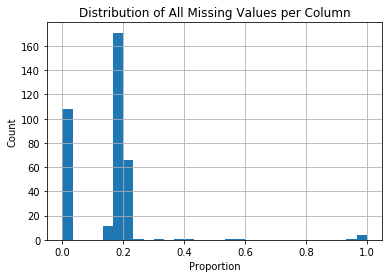

In [307]:
mailout_train_col_null=(mailout_train.isnull().sum()/len(mailout_train)).sort_values(ascending=False)
mailout_train_col_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Column');


In [308]:
mailout_train_remove_features=set(mailout_train_col_null[mailout_train_col_null>0.3].index)
print(mailout_train_remove_features)

{'KK_KUNDENTYP', 'AGER_TYP', 'KBA05_BAUMAX', 'ALTER_KIND3', 'ALTER_HH', 'ALTER_KIND4', 'ALTER_KIND1', 'TITEL_KZ', 'EXTSEL992', 'ALTER_KIND2'}


In [309]:
mailout_train_df=mailout_train.drop(labels=mailout_train_remove_features,axis=1)

In [310]:
mailout_train_df.set_index('LNR',inplace=True)

In [311]:
mailout_train_df[list(numerical_attribute)]
mailout_train_df[list(multiple_categories_attribute)]
mailout_train_df[list(binary_attribute)]
mailout_train_df.drop(labels=(set(mailout_train_df.columns)-numerical_attribute-multiple_categories_attribute-binary_attribute-set(['RESPONSE'])),axis=1,inplace=True)

In [312]:
mailout_train_df.shape

(42962, 333)

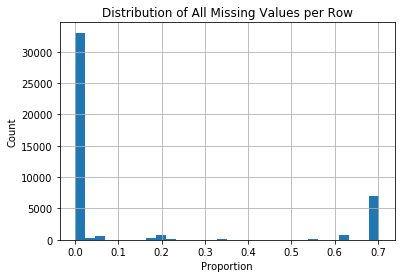

In [313]:
# deal with rows
mailout_train_row_null=(mailout_train_df.isnull().mean(axis=1)).sort_values(ascending=False)
mailout_train_row_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Row');

In [314]:
remove_mailout_train_rows=mailout_train_row_null[mailout_train_row_null>0.5].index
mailout_train_df.drop(index=remove_mailout_train_rows,axis=0,inplace=True)

In [315]:
mailout_train_df.shape

(35094, 333)

In [316]:
# deal with the numerical features
# deal with the 'MIN_GEBAEUDEJAHR' , 'GEBURTSJAHR'
mailout_train_df['MIN_GEBAEUDEJAHR']=2017-mailout_train_df['MIN_GEBAEUDEJAHR']
mailout_train_df['GEBURTSJAHR']=2017-mailout_train_df['GEBURTSJAHR']

# fill the missing data in numerical_attribute
for l in numerical_attribute:
    mailout_train_df[l]=mailout_train_df[l].fillna(value=round(mailout_train_df[l].mean()))

In [317]:
# deal with the multiple categories features
# deal with the 'CAMEO_DEUG_2015',replace the X value by np.nan
mailout_train_df['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)

mailout_train_df['CAMEO_DEUG_2015']=mailout_train_df['CAMEO_DEUG_2015'].astype('float')

mailout_train_df[list(multiple_categories_attribute)]=mailout_train_df[list(multiple_categories_attribute)].astype('float')

for l in multiple_categories_attribute:
    mailout_train_df[l].fillna(mailout_train_df[l].mode()[0], inplace=True)
    
mailout_train_df[list(multiple_categories_attribute)]=mailout_train_df[list(multiple_categories_attribute)].astype('int')

In [318]:
# deal with the binary features
mailout_train_df.loc[mailout_train_df['OST_WEST_KZ'] =='W','OST_WEST_KZ']=1
mailout_train_df.loc[mailout_train_df['OST_WEST_KZ'] =='O','OST_WEST_KZ']=0
# ANREDE_KZ
mailout_train_df['ANREDE_KZ']=mailout_train_df['ANREDE_KZ']-1
# VERS_TYP
mailout_train_df['VERS_TYP']=mailout_train_df['VERS_TYP']-1


for l in binary_attribute:
    mailout_train_df[l].fillna(mailout_train_df[l].mode()[0], inplace=True)

mailout_train_df[list(binary_attribute)]=mailout_train_df[list(binary_attribute)].astype('int')

In [320]:
scaled = scaler.fit_transform(mailout_train_df[list(numerical_attribute|multiple_categories_attribute)]) 
mailout_train_df_scaled_df=pd.DataFrame(scaled, columns=list(numerical_attribute|multiple_categories_attribute),index=mailout_train_df.index)

my_mailout_train_df=pd.concat([mailout_train_df_scaled_df, mailout_train_df[list(binary_attribute|set(['RESPONSE']))]], axis=1)


my_mailout_train_df.shape

(35094, 333)

In [321]:
(my_mailout_train_df.isnull().sum()).sum()

0

In [327]:
my_mailout_train_df.to_pickle("my_mailout_train_df.pkl")

In [328]:
X = my_mailout_train_df.drop('RESPONSE',axis=1)
y = my_mailout_train_df['RESPONSE']

In [329]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.05, random_state=0)

In [330]:
y_val.value_counts()

0    1733
1      22
Name: RESPONSE, dtype: int64

### Algorithm comparison
I would choose several common algorithms to implement supervised learning, and choose the best ones for the next optimization.

In [415]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_preds = clf.predict_proba(X_val)
score = metrics.roc_auc_score(y_val,y_preds[:,1])
print(score)

0.7039290772701045


In [416]:
print(y_preds)

[[9.83190498e-01 1.68095019e-02]
 [9.99896967e-01 1.03032643e-04]
 [9.98907830e-01 1.09216983e-03]
 ...
 [9.95108147e-01 4.89185292e-03]
 [9.98746808e-01 1.25319214e-03]
 [9.98971134e-01 1.02886573e-03]]


In [417]:
# DecisionTreeClassifier
from sklearn import tree
clf = tree.DecisionTreeClassifier().fit(X_train, y_train)
y_preds = clf.predict_proba(X_val)
score = metrics.roc_auc_score(y_val, y_preds[:,1])
print(score)

0.5132062109846299


In [418]:
# Simple network
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.utils.data
from torch.autograd import Variable
torch.set_default_dtype(torch.float64)

In [419]:
torch_tensor_X_train = torch.tensor(X_train.values)
torch_tensor_y_train = torch.tensor(y_train.values,dtype=torch.long)
torch_tensor_X_val = torch.tensor(X_val.values)
torch_tensor_y_val = torch.tensor(y_val.values,dtype=torch.long)

In [420]:
train_batch_size =35094
test_batch_size =35094

In [421]:
train = torch.utils.data.TensorDataset(torch_tensor_X_train,torch_tensor_y_train)
test = torch.utils.data.TensorDataset(torch_tensor_X_val,torch_tensor_y_val)

train_loader = torch.utils.data.DataLoader(train, batch_size = train_batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = test_batch_size, shuffle = False)

In [424]:
class NetSimple(torch.nn.Module):  # simpleNet
    def __init__(self, in_dim, n_hidden_1, out_dim): 
        super(NetSimple, self).__init__()  
        self.layer1 = nn.Linear(in_dim, n_hidden_1)
        self.layer2 = nn.Linear(n_hidden_1, out_dim)
 
    def forward(self, x): 
        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [425]:
model = NetSimple(in_dim=332, n_hidden_1=120, out_dim=2)  # two classification has two n_features
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)  
criterion = torch.nn.CrossEntropyLoss()  # loss_function

In [426]:
epochs =300
train_losses, test_losses = [] ,[]
for epoch in range(epochs):
    running_loss = 0
    for x1,y1 in train_loader:
        if torch.cuda.is_available():
            x1 = x1.cuda()
            y1 = y1.cuda()
        else:
            x1 = Variable(x1)
            y1= Variable(y1)
        out = model(x1)  
        loss = criterion(out, y1)  
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad(): #Turning off gradients to speed up
            model.eval()
            for x2,y2 in test_loader:
                if torch.cuda.is_available():
                    x2 = x2.cuda()
                    y2 = y2.cuda()
                else:
                    x2 = Variable(x2)
                    y2= Variable(y2)
                log_ps = model(x2)
                test_loss += criterion(log_ps,y2)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == y2.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

        prediction = torch.max(out, 1)[1].cpu()  ##返回每一行中最大值的那个元素，且返回其索引  torch.max()[1]， 只返回最大值的每个索引
#         pred_y = prediction.data.numpy().squeeze()
#         target_y = y_train_Variable.data.numpy()
        print(accuracy)

Epoch: 1/300..  Training Loss: 0.715..  Test Loss: 0.708..  Test Accuracy: 0.499
tensor(0.4991, dtype=torch.float32)
Epoch: 2/300..  Training Loss: 0.709..  Test Loss: 0.702..  Test Accuracy: 0.515
tensor(0.5145, dtype=torch.float32)
Epoch: 3/300..  Training Loss: 0.704..  Test Loss: 0.696..  Test Accuracy: 0.528
tensor(0.5276, dtype=torch.float32)
Epoch: 4/300..  Training Loss: 0.698..  Test Loss: 0.691..  Test Accuracy: 0.544
tensor(0.5436, dtype=torch.float32)
Epoch: 5/300..  Training Loss: 0.693..  Test Loss: 0.685..  Test Accuracy: 0.556
tensor(0.5561, dtype=torch.float32)
Epoch: 6/300..  Training Loss: 0.687..  Test Loss: 0.680..  Test Accuracy: 0.568
tensor(0.5681, dtype=torch.float32)
Epoch: 7/300..  Training Loss: 0.682..  Test Loss: 0.674..  Test Accuracy: 0.584
tensor(0.5840, dtype=torch.float32)
Epoch: 8/300..  Training Loss: 0.677..  Test Loss: 0.669..  Test Accuracy: 0.596
tensor(0.5960, dtype=torch.float32)
Epoch: 9/300..  Training Loss: 0.671..  Test Loss: 0.664..  Test

Epoch: 71/300..  Training Loss: 0.431..  Test Loss: 0.424..  Test Accuracy: 0.964
tensor(0.9635, dtype=torch.float32)
Epoch: 72/300..  Training Loss: 0.429..  Test Loss: 0.421..  Test Accuracy: 0.964
tensor(0.9641, dtype=torch.float32)
Epoch: 73/300..  Training Loss: 0.426..  Test Loss: 0.418..  Test Accuracy: 0.964
tensor(0.9641, dtype=torch.float32)
Epoch: 74/300..  Training Loss: 0.423..  Test Loss: 0.416..  Test Accuracy: 0.966
tensor(0.9658, dtype=torch.float32)
Epoch: 75/300..  Training Loss: 0.420..  Test Loss: 0.413..  Test Accuracy: 0.967
tensor(0.9670, dtype=torch.float32)
Epoch: 76/300..  Training Loss: 0.417..  Test Loss: 0.410..  Test Accuracy: 0.968
tensor(0.9681, dtype=torch.float32)
Epoch: 77/300..  Training Loss: 0.415..  Test Loss: 0.407..  Test Accuracy: 0.969
tensor(0.9692, dtype=torch.float32)
Epoch: 78/300..  Training Loss: 0.412..  Test Loss: 0.405..  Test Accuracy: 0.970
tensor(0.9698, dtype=torch.float32)
Epoch: 79/300..  Training Loss: 0.409..  Test Loss: 0.40

Epoch: 141/300..  Training Loss: 0.281..  Test Loss: 0.275..  Test Accuracy: 0.988
tensor(0.9880, dtype=torch.float32)
Epoch: 142/300..  Training Loss: 0.280..  Test Loss: 0.273..  Test Accuracy: 0.988
tensor(0.9880, dtype=torch.float32)
Epoch: 143/300..  Training Loss: 0.278..  Test Loss: 0.272..  Test Accuracy: 0.988
tensor(0.9880, dtype=torch.float32)
Epoch: 144/300..  Training Loss: 0.277..  Test Loss: 0.270..  Test Accuracy: 0.988
tensor(0.9880, dtype=torch.float32)
Epoch: 145/300..  Training Loss: 0.275..  Test Loss: 0.269..  Test Accuracy: 0.988
tensor(0.9880, dtype=torch.float32)
Epoch: 146/300..  Training Loss: 0.273..  Test Loss: 0.267..  Test Accuracy: 0.988
tensor(0.9880, dtype=torch.float32)
Epoch: 147/300..  Training Loss: 0.272..  Test Loss: 0.266..  Test Accuracy: 0.988
tensor(0.9880, dtype=torch.float32)
Epoch: 148/300..  Training Loss: 0.270..  Test Loss: 0.264..  Test Accuracy: 0.988
tensor(0.9880, dtype=torch.float32)
Epoch: 149/300..  Training Loss: 0.269..  Test L

Epoch: 210/300..  Training Loss: 0.199..  Test Loss: 0.194..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 211/300..  Training Loss: 0.198..  Test Loss: 0.193..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 212/300..  Training Loss: 0.197..  Test Loss: 0.192..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 213/300..  Training Loss: 0.196..  Test Loss: 0.191..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 214/300..  Training Loss: 0.196..  Test Loss: 0.190..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 215/300..  Training Loss: 0.195..  Test Loss: 0.189..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 216/300..  Training Loss: 0.194..  Test Loss: 0.188..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 217/300..  Training Loss: 0.193..  Test Loss: 0.188..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 218/300..  Training Loss: 0.192..  Test L

Epoch: 279/300..  Training Loss: 0.152..  Test Loss: 0.148..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 280/300..  Training Loss: 0.152..  Test Loss: 0.147..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 281/300..  Training Loss: 0.151..  Test Loss: 0.147..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 282/300..  Training Loss: 0.151..  Test Loss: 0.146..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 283/300..  Training Loss: 0.150..  Test Loss: 0.146..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 284/300..  Training Loss: 0.150..  Test Loss: 0.145..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 285/300..  Training Loss: 0.149..  Test Loss: 0.145..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 286/300..  Training Loss: 0.149..  Test Loss: 0.144..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 287/300..  Training Loss: 0.148..  Test L

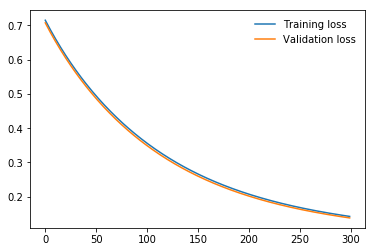

In [427]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### improving the algorithms
- From the results of the above three algorithms, the neural network works best, but it is likely to overfit, I will further optimize it.


In [389]:
class Net(torch.nn.Module):  # 3 layer net
    def __init__(self, in_dim, n_hidden_1, n_hidden_2, out_dim): 
        super(Net, self).__init__()  
        self.layer1 = nn.Sequential(nn.Linear(in_dim, n_hidden_1), nn.BatchNorm1d(n_hidden_1),nn.Dropout(0.5), nn.ReLU(True))
        self.layer2 = nn.Sequential(nn.Linear(n_hidden_1, n_hidden_2), nn.BatchNorm1d(n_hidden_2),nn.Dropout(0.5), nn.ReLU(True))
        self.layer3 = nn.Sequential(nn.Linear(n_hidden_2, out_dim))
 
    def forward(self, x): 
#         x = F.relu(self.hidden(x)) 
#         x = self.out(x) 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

In [390]:
model = Net(in_dim=332, n_hidden_1=120,n_hidden_2=10, out_dim=2)  # two classification has two n_features
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)  
criterion = torch.nn.CrossEntropyLoss()  # loss_function

In [391]:
epochs =300
train_losses, test_losses = [] ,[]
for epoch in range(epochs):
    running_loss = 0
    for x1,y1 in train_loader:
        if torch.cuda.is_available():
            x1 = x1.cuda()
            y1 = y1.cuda()
        else:
            x1 = Variable(x1)
            y1= Variable(y1)
        out = model(x1)  
        loss = criterion(out, y1)  
        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad(): #Turning off gradients to speed up
            model.eval()
            for x2,y2 in test_loader:
                if torch.cuda.is_available():
                    x2 = x2.cuda()
                    y2 = y2.cuda()
                else:
                    x2 = Variable(x2)
                    y2= Variable(y2)
                log_ps = model(x2)
                test_loss += criterion(log_ps,y2)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim = 1)
                equals = top_class == y2.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        model.train()        
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

        prediction = torch.max(out, 1)[1].cpu()  ##返回每一行中最大值的那个元素，且返回其索引  torch.max()[1]， 只返回最大值的每个索引
#         pred_y = prediction.data.numpy().squeeze()
#         target_y = y_train_Variable.data.numpy()
        print(accuracy)

Epoch: 1/300..  Training Loss: 0.651..  Test Loss: 0.669..  Test Accuracy: 0.986
tensor(0.9858, dtype=torch.float32)
Epoch: 2/300..  Training Loss: 0.649..  Test Loss: 0.665..  Test Accuracy: 0.986
tensor(0.9858, dtype=torch.float32)
Epoch: 3/300..  Training Loss: 0.645..  Test Loss: 0.662..  Test Accuracy: 0.986
tensor(0.9863, dtype=torch.float32)
Epoch: 4/300..  Training Loss: 0.642..  Test Loss: 0.658..  Test Accuracy: 0.986
tensor(0.9863, dtype=torch.float32)
Epoch: 5/300..  Training Loss: 0.639..  Test Loss: 0.655..  Test Accuracy: 0.986
tensor(0.9858, dtype=torch.float32)
Epoch: 6/300..  Training Loss: 0.636..  Test Loss: 0.651..  Test Accuracy: 0.986
tensor(0.9858, dtype=torch.float32)
Epoch: 7/300..  Training Loss: 0.633..  Test Loss: 0.648..  Test Accuracy: 0.985
tensor(0.9852, dtype=torch.float32)
Epoch: 8/300..  Training Loss: 0.629..  Test Loss: 0.645..  Test Accuracy: 0.985
tensor(0.9852, dtype=torch.float32)
Epoch: 9/300..  Training Loss: 0.625..  Test Loss: 0.641..  Test

Epoch: 71/300..  Training Loss: 0.463..  Test Loss: 0.478..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 72/300..  Training Loss: 0.462..  Test Loss: 0.476..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 73/300..  Training Loss: 0.459..  Test Loss: 0.474..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 74/300..  Training Loss: 0.457..  Test Loss: 0.472..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 75/300..  Training Loss: 0.456..  Test Loss: 0.470..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 76/300..  Training Loss: 0.453..  Test Loss: 0.469..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 77/300..  Training Loss: 0.451..  Test Loss: 0.467..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 78/300..  Training Loss: 0.451..  Test Loss: 0.465..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 79/300..  Training Loss: 0.448..  Test Loss: 0.46

Epoch: 141/300..  Training Loss: 0.357..  Test Loss: 0.376..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 142/300..  Training Loss: 0.355..  Test Loss: 0.375..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 143/300..  Training Loss: 0.355..  Test Loss: 0.374..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 144/300..  Training Loss: 0.353..  Test Loss: 0.373..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 145/300..  Training Loss: 0.353..  Test Loss: 0.372..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 146/300..  Training Loss: 0.352..  Test Loss: 0.371..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 147/300..  Training Loss: 0.349..  Test Loss: 0.370..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 148/300..  Training Loss: 0.349..  Test Loss: 0.369..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 149/300..  Training Loss: 0.347..  Test L

Epoch: 210/300..  Training Loss: 0.292..  Test Loss: 0.312..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 211/300..  Training Loss: 0.293..  Test Loss: 0.311..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 212/300..  Training Loss: 0.290..  Test Loss: 0.310..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 213/300..  Training Loss: 0.290..  Test Loss: 0.309..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 214/300..  Training Loss: 0.290..  Test Loss: 0.308..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 215/300..  Training Loss: 0.287..  Test Loss: 0.308..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 216/300..  Training Loss: 0.286..  Test Loss: 0.307..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 217/300..  Training Loss: 0.287..  Test Loss: 0.306..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 218/300..  Training Loss: 0.286..  Test L

Epoch: 279/300..  Training Loss: 0.249..  Test Loss: 0.266..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 280/300..  Training Loss: 0.247..  Test Loss: 0.266..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 281/300..  Training Loss: 0.247..  Test Loss: 0.265..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 282/300..  Training Loss: 0.245..  Test Loss: 0.265..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 283/300..  Training Loss: 0.246..  Test Loss: 0.264..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 284/300..  Training Loss: 0.245..  Test Loss: 0.263..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 285/300..  Training Loss: 0.245..  Test Loss: 0.263..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 286/300..  Training Loss: 0.245..  Test Loss: 0.262..  Test Accuracy: 0.987
tensor(0.9875, dtype=torch.float32)
Epoch: 287/300..  Training Loss: 0.244..  Test L

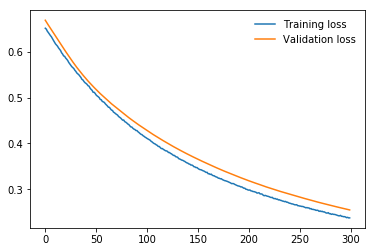

In [399]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [400]:
mailout_test = pd.read_csv('./data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

c:\program files\python3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [401]:
mailout_test.set_index('LNR',inplace=True)

In [402]:
mailout_test=unknown2missing(mailout_test)
mailout_test['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)

In [403]:
print(mailout_test.isnull().mean().mean())

0.14858425954383528


In [404]:
# dorp the features with mailout_train
mailout_test.drop(labels=list(set(mailout_test.columns)-set(mailout_train.columns)),axis=1,inplace=True)

In [405]:
mailout_test.shape

(42833, 365)

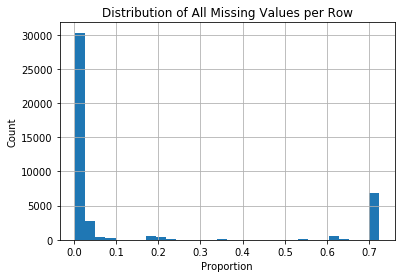

In [406]:
test_row_null=(mailout_test.isnull().mean(axis=1)).sort_values(ascending=False)
test_row_null.hist(bins=30)
plt.xlabel('Proportion')
plt.ylabel('Count')
plt.title('Distribution of All Missing Values per Row');


In [407]:
remove_mailout_test_rows=test_row_null[test_row_null>0.5].index
len(remove_mailout_test_rows)

7734

In [408]:
# deal with the numerical features
# deal with the 'MIN_GEBAEUDEJAHR' , 'GEBURTSJAHR'
mailout_test['MIN_GEBAEUDEJAHR']=2017-mailout_test['MIN_GEBAEUDEJAHR']
mailout_test['GEBURTSJAHR']=2017-mailout_test['GEBURTSJAHR']

# fill the missing data in numerical_attribute
for l in numerical_attribute:
    mailout_test[l]=mailout_test[l].fillna(value=round(mailout_test[l].mean()))
	
# deal with the multiple categories features
# deal with the 'CAMEO_DEUG_2015',replace the X value by np.nan
mailout_test['CAMEO_DEUG_2015'].replace('X',np.nan,inplace=True)

mailout_test['CAMEO_DEUG_2015']=mailout_test['CAMEO_DEUG_2015'].astype('float')

mailout_test[list(multiple_categories_attribute)]=mailout_test[list(multiple_categories_attribute)].astype('float')

for l in multiple_categories_attribute:
    mailout_test[l].fillna(mailout_test[l].mode()[0], inplace=True)
    
mailout_test[list(multiple_categories_attribute)]=mailout_test[list(multiple_categories_attribute)].astype('int')

# deal with the binary features
mailout_test.loc[mailout_test['OST_WEST_KZ'] =='W','OST_WEST_KZ']=1
mailout_test.loc[mailout_test['OST_WEST_KZ'] =='O','OST_WEST_KZ']=0
# ANREDE_KZ
mailout_test['ANREDE_KZ']=mailout_test['ANREDE_KZ']-1
# VERS_TYP
mailout_test['VERS_TYP']=mailout_test['VERS_TYP']-1


for l in binary_attribute:
    mailout_test[l].fillna(mailout_test[l].mode()[0], inplace=True)

mailout_test[list(binary_attribute)]=mailout_test[list(binary_attribute)].astype('int')

scaled = scaler.fit_transform(mailout_test[list(numerical_attribute|multiple_categories_attribute)]) 
mailout_train_df_scaled_df=pd.DataFrame(scaled, columns=list(numerical_attribute|multiple_categories_attribute),index=mailout_test.index)
my_mailout_test=pd.concat([mailout_train_df_scaled_df, mailout_test[list(binary_attribute)]], axis=1)

In [409]:
my_mailout_test.isnull().sum().sum()

0

In [410]:
my_mailout_test.shape

(42833, 332)

In [411]:
# ready for predict
test_dataset = torch.tensor(my_mailout_test.values)
new_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 42833, shuffle = False)

In [412]:
results = []
with torch.no_grad():
    model.eval()
    for t in new_test_loader:
        if torch.cuda.is_available():
            t = t.cuda()
        output = model(t)
        output=output.cpu()
        sm = torch.nn.Softmax()
        probabilities = sm(output) 
        print(probabilities.numpy()[:,1]) 
        results=probabilities.numpy()[:,1]
        #Converted to probabilities
#         ps = torch.exp(output)
#         top_p, top_class = ps.topk(1, dim = 1)
#         results += top_class.numpy().tolist()

[0.21724178 0.16086566 0.16001473 ... 0.24575106 0.20669511 0.17603484]


c:\program files\python3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


In [413]:
submissions=pd.DataFrame({"LNR": mailout_test.index,
                         "RESPONSE": results})
submissions.to_csv("my_submissions.csv", index=False, header=True)

In [414]:
submissions['RESPONSE'].value_counts()

0.164046    1991
0.163039    1226
0.162647     891
0.161390     768
0.160678     459
0.159254     303
0.289047      20
0.179652       2
0.239788       1
0.254907       1
0.212785       1
0.261246       1
0.275629       1
0.127365       1
0.154938       1
0.223721       1
0.206374       1
0.220372       1
0.233798       1
0.159405       1
0.190544       1
0.203309       1
0.222409       1
0.243911       1
0.260682       1
0.251174       1
0.240480       1
0.250664       1
0.173776       1
0.124711       1
            ... 
0.197431       1
0.189773       1
0.230671       1
0.185396       1
0.210901       1
0.210924       1
0.241626       1
0.237532       1
0.249081       1
0.205352       1
0.222053       1
0.213553       1
0.221294       1
0.226069       1
0.229941       1
0.162711       1
0.211451       1
0.193163       1
0.172498       1
0.223964       1
0.254605       1
0.206734       1
0.219159       1
0.265386       1
0.261213       1
0.226658       1
0.153114       1
0.250781      

## Conclusion
1. The difficulty of the dataset in this project  was that there are many dimensions, the description of each dimension was not clear, and the difficulty of cleaning was relatively large.
2. There were many features in this project that belong to category features. The use of PCA for dimensionality reduction was not particularly good. The Kmeans algorithm was not particularly effective for such features. The next step would be to try AUTOENCODING and K-prototype.
3. Supervised learning using neural networks was over-fitting. It was necessary to further increase the complexity of the dimensions. I would try to do the ONE-HOT processing of the category features.